In [1]:
import re
import numpy as np

In [2]:
with open("./data.txt") as f:
    data = f.readlines()
    
with open("./data1.txt") as f:
    data1 = f.readlines()

In [3]:
data = data + data1
data

['begin kick: (-1693.76:-4086.46)(83.1149:509.213)\n',
 '(-1682.58:-4057.06)(202.106:763.305)11494\n',
 '(-1669.66:-4020.64)(338.109:1079.6)15901\n',
 '(-1658.34:-3987.63)(464.468:1389.63)17152\n',
 '(-1645.89:-3949.19)(581.425:1703.52)15458\n',
 '(-1636.32:-3908.68)(666.014:2007.2)17702\n',
 '(-1626.14:-3868.83)(726.977:2276.37)7093\n',
 '(-1615.18:-3822.64)(766.481:2518.96)10554\n',
 '(-1606.16:-3777.75)(788.071:2750.5)16950\n',
 '(-1598.41:-3730.65)(784.863:2956.54)15279\n',
 '(-1589.9:-3681.91)(770.816:3139.92)7969\n',
 '(-1582.6:-3627.56)(743.88:3327.77)12223\n',
 '(-1576.08:-3574.92)(706.317:3493.34)17768\n',
 '(-1571.62:-3516.08)(652.916:3668.67)11380\n',
 '(-1565.67:-3459.61)(602.558:3822.09)20081\n',
 '(-1562.2:-3398.96)(543.445:3974.38)8033\n',
 '(-1559.79:-3334.36)(477.191:4137.4)14145\n',
 '(-1557.99:-3272.82)(408.097:4275.97)12173\n',
 '(-1555.88:-3205.88)(344.563:4420.34)19462\n',
 '(-1557.54:-3136.26)(267.257:4572.82)10981\n',
 '(-1558.17:-3065.74)(193.454:4723.68)18896\

In [4]:
def parse_pos_vel(line):
    pos, vel = re.findall(r'[(](.*?)[)]', line)
    pos = list(map(float, pos.split(':')))
    vel = list(map(float, vel.split(':')))
    return (pos, vel)

def parse_timeslot(line):
    return float(re.findall(r'[0-9]*[\n]', line)[0].strip())


def preprocess(init_data):
    X = []
    Y = []
    time_feature = []
    for item in init_data:
        tmp_item = item.split()
        if tmp_item[0] == 'begin':
            # 获取原始的坐标pos=(x,y)和速度vel=(vx,vy)
            pos, vel = parse_pos_vel(tmp_item[2])
            
            # begin即初始时间戳为0
            time_slot = [0,]
            
            # 特征合并
            feature = pos + vel + time_slot # feature = [pos_x, pos_y, speed_x, speed_y, time_slot]
            
            time_feature.append(feature)
        elif tmp_item[0] == 'hit':
            # 添加最后落球点的坐标
            Y.append([last_feature[0], last_feature[1]])
            # 删除训练样本点中的最后一帧数据(落球点)
            del time_feature[-1]
            # 令训练样本点的第一帧数据(踢球点)的pos_x=0, pos_y=0
            time_feature[0][0] = 0
            time_feature[0][1] = 0
            # 将该样本点加入训练集X中
            X.append(time_feature)
            # 样本点清空
            time_feature = []
        else:
            pos, vel = parse_pos_vel(item)
            time_slot = [parse_timeslot(item) + time_feature[-1][-1]]
            feature = pos + vel + time_slot
            # pos_x, pos_y 改成相对于踢球点的坐标
            feature[0] = feature[0] - time_feature[0][0]
            feature[1] = feature[1] - time_feature[0][1]
            
            time_feature.append(feature)
            
        last_feature = feature
    return (X, Y)

In [5]:
from sklearn.utils import shuffle

def split_train_test_data(data, label):
    '''
    shuffle随机划分训练集和测试集
    '''
    n = len(data)
    n_train = int(n * 0.8)
    n_test  = n - n_train

    shuffle_data, shuffle_label = shuffle(data, label)

    training_data = shuffle_data[: n_train]
    training_label = shuffle_label[: n_train]
    testing_data = shuffle_data[n_train: ]
    testing_label = shuffle_label[n_train: ]
    
    return training_data, training_label, testing_data, testing_label 

In [6]:
def generate_data(data, label):
    '''
    从一个挑射轨迹中累次递增每5帧取出一个样本点，生成更多数据集
    '''
    new_data = []
    new_label = []
    for i in range(len(data)):
        for j in range(15, len(data[i]) + 1, 5):
            new_label.append(label[i])
            new_data.append(data[i][:j])
            
    return new_data, new_label

In [7]:
# 数据预处理，获取整体数据
X, Y = preprocess(data)

# 切分时间序列，获得更多的数据
X, Y = generate_data(X, Y)

print('total data size:', len(X))

# 划分训练集和测试集
train_X, train_Y, test_X, test_Y = split_train_test_data(X, Y)

total data size: 487


In [8]:
X

[[[0, 0, 83.1149, 509.213, 0],
  [11.180000000000064, 29.40000000000009, 202.106, 763.305, 11494.0],
  [24.09999999999991, 65.82000000000016, 338.109, 1079.6, 27395.0],
  [35.42000000000007, 98.82999999999993, 464.468, 1389.63, 44547.0],
  [47.86999999999989, 137.26999999999998, 581.425, 1703.52, 60005.0],
  [57.440000000000055, 177.7800000000002, 666.014, 2007.2, 77707.0],
  [67.61999999999989, 217.6300000000001, 726.977, 2276.37, 84800.0],
  [78.57999999999993, 263.82000000000016, 766.481, 2518.96, 95354.0],
  [87.59999999999991, 308.71000000000004, 788.071, 2750.5, 112304.0],
  [95.34999999999991, 355.80999999999995, 784.863, 2956.54, 127583.0],
  [103.8599999999999, 404.5500000000002, 770.816, 3139.92, 135552.0],
  [111.16000000000008, 458.9000000000001, 743.88, 3327.77, 147775.0],
  [117.68000000000006, 511.53999999999996, 706.317, 3493.34, 165543.0],
  [122.1400000000001, 570.3800000000001, 652.916, 3668.67, 176923.0],
  [128.08999999999992, 626.8499999999999, 602.558, 3822.09, 1

In [9]:
import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as Data

In [10]:
train_X = [torch.FloatTensor(item) for item in train_X] 
test_X = [torch.FloatTensor(item) for item in test_X]

train_X

[tensor([[0.0000e+00, 0.0000e+00, 6.2496e+02, 8.9540e+02, 0.0000e+00],
         [3.9010e+01, 3.6870e+01, 9.3975e+02, 1.1429e+03, 1.7170e+04],
         [7.4290e+01, 7.3560e+01, 1.2738e+03, 1.4265e+03, 3.3000e+04],
         [1.1019e+02, 1.1588e+02, 1.5971e+03, 1.7440e+03, 3.7658e+04],
         [1.4624e+02, 1.5822e+02, 1.8739e+03, 2.0414e+03, 5.2534e+04],
         [1.8587e+02, 2.1031e+02, 2.1439e+03, 2.3857e+03, 6.8041e+04],
         [2.2383e+02, 2.5751e+02, 2.3689e+03, 2.6930e+03, 8.3879e+04],
         [2.6670e+02, 3.1072e+02, 2.5767e+03, 2.9884e+03, 1.1484e+05],
         [3.0387e+02, 3.6408e+02, 2.7233e+03, 3.2535e+03, 1.2143e+05],
         [3.4867e+02, 4.2568e+02, 2.8651e+03, 3.5276e+03, 1.3305e+05],
         [4.3323e+02, 5.4811e+02, 3.2297e+03, 4.1479e+03, 1.4983e+05],
         [4.7558e+02, 6.2092e+02, 3.4544e+03, 4.6419e+03, 1.6171e+05],
         [5.1765e+02, 6.8527e+02, 3.5712e+03, 4.9665e+03, 1.7539e+05],
         [5.6490e+02, 7.6030e+02, 3.6415e+03, 5.2220e+03, 1.8976e+05],
      

In [11]:
def _normalize(data, mean=None, std=None):
    '''
    变长时间序列tensor的正规化函数，同时对5个feature进行正规化
    并以list形式返回x,y的mean和std
    '''
    
    # 如果没有给定mean和std，则默认对数据本身求值
    if mean is None and std == None:
        # 合并tensor
        total = data[0]
        for i in range(1, len(data)):
            total = torch.cat((total, data[i]), 0)
        # 求mean和std
        mean = total.mean(dim=0)
        std = total.std(dim=0)
        
    # 正规化
    for i in range(len(data)):
        data[i] = (data[i] - mean) / std

    return mean, std

In [12]:
mean, std = _normalize(train_X)

mean_for_predict = mean[:2].numpy().tolist()
std_for_predict = std[:2].numpy().tolist()

In [13]:
_, _ = _normalize(test_X, mean, std)

In [14]:
print('train_X size:', len(train_X))
train_X  

train_X size: 389


[tensor([[ 0.1896, -0.1788,  0.4226,  0.1866, -0.9231],
         [ 0.2560, -0.1493,  0.6411,  0.2683, -0.8962],
         [ 0.3160, -0.1199,  0.8729,  0.3618, -0.8714],
         [ 0.3771, -0.0860,  1.0973,  0.4666, -0.8641],
         [ 0.4384, -0.0520,  1.2893,  0.5647, -0.8408],
         [ 0.5059, -0.0103,  1.4768,  0.6782, -0.8165],
         [ 0.5705,  0.0275,  1.6329,  0.7796, -0.7917],
         [ 0.6434,  0.0702,  1.7771,  0.8770, -0.7432],
         [ 0.7067,  0.1129,  1.8788,  0.9645, -0.7329],
         [ 0.7829,  0.1623,  1.9772,  1.0549, -0.7147],
         [ 0.9268,  0.2604,  2.2302,  1.2595, -0.6884],
         [ 0.9988,  0.3188,  2.3862,  1.4224, -0.6697],
         [ 1.0704,  0.3703,  2.4672,  1.5295, -0.6483],
         [ 1.1508,  0.4305,  2.5161,  1.6138, -0.6258],
         [ 1.2277,  0.4972,  2.5322,  1.6932, -0.6067],
         [ 1.2991,  0.5583,  2.5131,  1.7495, -0.5822],
         [ 1.3803,  0.6266,  2.4970,  1.8040, -0.5532],
         [ 1.4534,  0.6924,  2.4644,  1.8472, -0

In [15]:
print('test_X size:', len(test_X))
test_X

test_X size: 98


[tensor([[ 0.1896, -0.1788,  0.4397, -0.4201, -0.9231],
         [ 0.2307, -0.2095,  0.5727, -0.5339, -0.8975],
         [ 0.2710, -0.2414,  0.7080, -0.6501, -0.8706],
         [ 0.3134, -0.2731,  0.8391, -0.7581, -0.8466],
         [ 0.3613, -0.3072,  0.9625, -0.8520, -0.8360],
         [ 0.4115, -0.3419,  1.0893, -0.9406, -0.8155],
         [ 0.4647, -0.3775,  1.2103, -1.0171, -0.7921],
         [ 0.5189, -0.4145,  1.3204, -1.0833, -0.7655],
         [ 0.5751, -0.4522,  1.4199, -1.1396, -0.7393],
         [ 0.6400, -0.4912,  1.5256, -1.1884, -0.7280],
         [ 0.6979, -0.5287,  1.6102, -1.2247, -0.7082],
         [ 0.7639, -0.5695,  1.6940, -1.2584, -0.6817],
         [ 0.8343, -0.6114,  1.7818, -1.2906, -0.6605],
         [ 0.9039, -0.6527,  1.8627, -1.3175, -0.6365],
         [ 0.9792, -0.6951,  1.9469, -1.3420, -0.6205],
         [ 1.0522, -0.7382,  2.0209, -1.3645, -0.6008],
         [ 1.1307, -0.7816,  2.0959, -1.3849, -0.5795],
         [ 1.2091, -0.8240,  2.1654, -1.3999, -0

In [16]:
print('mean for predict:', mean_for_predict)
print('std for predict:', std_for_predict)

mean for predict: [-111.42842102050781, 223.14161682128906]
std for predict: [587.6953735351562, 1247.880615234375]


In [17]:
train_Y = [torch.FloatTensor([(item[0] - mean_for_predict[0]) / std_for_predict[0], (item[1] - mean_for_predict[1]) / std_for_predict[1]]) for item in train_Y]
test_Y = [torch.FloatTensor([(item[0] - mean_for_predict[0]) / std_for_predict[0], (item[1] - mean_for_predict[1]) / std_for_predict[1]]) for item in test_Y]

In [18]:
print('train_Y size:', len(train_Y))
train_Y

train_Y size: 389


[tensor([3.1475, 2.7899]),
 tensor([-1.5456,  1.5513]),
 tensor([-4.2744, -3.4277]),
 tensor([-3.2154, -0.5089]),
 tensor([ 1.8699, -1.8864]),
 tensor([0.8828, 3.1489]),
 tensor([0.1241, 1.1273]),
 tensor([-0.4154, -3.1158]),
 tensor([-1.5456,  1.5513]),
 tensor([ 1.1483, -3.3390]),
 tensor([-0.4154, -3.1158]),
 tensor([-0.4154, -3.1158]),
 tensor([-2.6958,  0.9166]),
 tensor([ 1.0327, -1.7446]),
 tensor([ 0.1128, -0.3041]),
 tensor([ 1.1483, -3.3390]),
 tensor([ 3.9702, -0.3386]),
 tensor([ 1.4727, -2.5495]),
 tensor([ 2.5059, -2.0894]),
 tensor([5.3592, 2.1284]),
 tensor([-0.0008, -0.0460]),
 tensor([-1.5456,  1.5513]),
 tensor([-0.7008,  2.9487]),
 tensor([ 1.4727, -2.5495]),
 tensor([-0.6206, -2.8208]),
 tensor([-1.5456,  1.5513]),
 tensor([-1.5456,  1.5513]),
 tensor([-0.9237,  3.0467]),
 tensor([0.3222, 1.4594]),
 tensor([-1.2731,  3.4695]),
 tensor([ 1.1483, -3.3390]),
 tensor([-1.5456,  1.5513]),
 tensor([ 2.5059, -2.0894]),
 tensor([-2.6081,  2.9377]),
 tensor([-1.5456,  1.551

In [19]:
print('test_Y size:', len(test_Y))
test_Y

test_Y size: 98


[tensor([ 4.9247, -2.3579]),
 tensor([ 1.8622, -1.0455]),
 tensor([-2.2303,  1.0240]),
 tensor([-4.2744, -3.4277]),
 tensor([-0.7008,  2.9487]),
 tensor([-3.2154, -0.5089]),
 tensor([3.1475, 2.7899]),
 tensor([1.0186, 1.7602]),
 tensor([5.3592, 2.1284]),
 tensor([-1.5456,  1.5513]),
 tensor([5.3592, 2.1284]),
 tensor([-1.5456,  1.5513]),
 tensor([-3.2267,  1.6272]),
 tensor([-0.4284,  3.0978]),
 tensor([ 1.0327, -1.7446]),
 tensor([-1.5456,  1.5513]),
 tensor([-1.5456,  1.5513]),
 tensor([ 2.5059, -2.0894]),
 tensor([ 1.4727, -2.5495]),
 tensor([5.3592, 2.1284]),
 tensor([-0.5845,  1.5109]),
 tensor([-0.0008, -0.0460]),
 tensor([ 2.5059, -2.0894]),
 tensor([-3.2267,  1.6272]),
 tensor([-1.5456,  1.5513]),
 tensor([ 1.1244, -1.5787]),
 tensor([-0.9237,  3.0467]),
 tensor([ 1.3386, -2.1349]),
 tensor([-0.5401,  0.3447]),
 tensor([ 1.4727, -2.5495]),
 tensor([ 0.7892, -1.9724]),
 tensor([-0.4154, -3.1158]),
 tensor([-1.5456,  1.5513]),
 tensor([ 1.7269, -1.7307]),
 tensor([-0.4284,  3.097

In [20]:
class lstm_ball(nn.Module):
    def __init__(self):
        super(lstm_ball, self).__init__()
        
        # 如果batch_first为True，输入输出数据格式是(batch, seq_len, feature)
        self.lstm = nn.LSTM(input_size = 5, hidden_size = 32, num_layers = 2, dropout = 0.2, batch_first = True)
        self.last_layer = nn.Linear(32, 2)
        self.h = None
        self.c = None
        
    def forward(self, x):
        # lstm_out 的 dimension (batch, seq_len, hidden_size)
        lstm_out, (h, c) = self.lstm(x)
        # 取用lstm最后一层的hidden state
        last_h = lstm_out[:, -1, :]
        linear_out = self.last_layer(last_h)
        
        return linear_out

In [21]:
class BallData(Data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [22]:
ball_data = BallData(train_X, train_Y)

In [23]:
train_loader = DataLoader(ball_data, batch_size=1, shuffle=True)

In [24]:
# 用于比较输入输出的测试程序
net = lstm_ball()
for i, (x,y) in enumerate(train_loader):
    if i == 0:
        predict = net(x)
        
        print(x.shape, y.shape, predict.shape)
        print(x)
        print(y)
        print(predict)
    else:
        break

torch.Size([1, 30, 5]) torch.Size([1, 2]) torch.Size([1, 2])
tensor([[[ 0.1896, -0.1788,  0.4581,  0.2075, -0.9231],
         [ 0.2181, -0.1492,  0.5788,  0.3187, -0.8973],
         [ 0.2552, -0.1156,  0.6979,  0.4373, -0.8722],
         [ 0.2831, -0.0850,  0.7844,  0.5434, -0.8454],
         [ 0.3101, -0.0518,  0.8341,  0.6336, -0.8351],
         [ 0.3342, -0.0186,  0.8611,  0.7163, -0.8142],
         [ 0.3613,  0.0207,  0.8744,  0.7986, -0.7931],
         [ 0.3810,  0.0556,  0.8597,  0.8634, -0.7673],
         [ 0.4031,  0.0947,  0.8346,  0.9221, -0.7376],
         [ 0.4178,  0.1346,  0.7871,  0.9744, -0.7255],
         [ 0.4352,  0.1766,  0.7356,  1.0237, -0.7089],
         [ 0.4486,  0.2191,  0.6760,  1.0683, -0.6863],
         [ 0.4596,  0.2611,  0.6104,  1.1053, -0.6625],
         [ 0.4650,  0.3054,  0.5326,  1.1400, -0.6329],
         [ 0.4718,  0.3510,  0.4567,  1.1738, -0.6209],
         [ 0.4751,  0.3969,  0.3797,  1.2051, -0.6004],
         [ 0.4764,  0.4433,  0.3031,  1.233

In [25]:
def loss_for_test(test_X, test_Y, net):
    '''
    手动计算MSELoss
    '''
    total_loss = 0
    
    for i in range(len(test_X)):
        # 输入需要用unsqueeze在外面套上一层维度
        predict_Y = net(test_X[i].unsqueeze(0))
        # 输出需要去掉最外层的维度
        total_loss += sum((predict_Y.squeeze() - test_Y[i])**2)
        break
        
    mseloss = total_loss / (2 * len(test_X))
    
    return mseloss
  
# # test for print
# loss = loss_for_test(test_X, test_Y, net)
# print(loss)

In [26]:
ball_net = lstm_ball()
optimizer = torch.optim.Adam(ball_net.parameters(), lr = 0.001)
loss_func = nn.MSELoss()

train_loss = []
test_loss = []

EPOCH = 50
for i in range(EPOCH):
    ball_net.train()
    for step, (x, y) in enumerate(train_loader):
        predict_y = ball_net(x)
        loss = loss_func(predict_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print("train: epoch_%d  step_%d  loss=%f"%(i, step, loss.item()))
        
        loss = loss_for_test(test_X, test_Y, ball_net)
        test_loss.append(loss.item())
#         print("test:  epoch_%d  step_%d  loss=%f"%(i, step, loss.item()))

train: epoch_0  step_0  loss=5.027486
train: epoch_0  step_1  loss=4.925371
train: epoch_0  step_2  loss=4.001119
train: epoch_0  step_3  loss=4.005215
train: epoch_0  step_4  loss=15.008356
train: epoch_0  step_5  loss=4.648188
train: epoch_0  step_6  loss=5.388827
train: epoch_0  step_7  loss=2.364139
train: epoch_0  step_8  loss=5.031388
train: epoch_0  step_9  loss=0.596680
train: epoch_0  step_10  loss=7.710159
train: epoch_0  step_11  loss=1.114764
train: epoch_0  step_12  loss=0.018554
train: epoch_0  step_13  loss=1.362544
train: epoch_0  step_14  loss=4.084046
train: epoch_0  step_15  loss=4.944603
train: epoch_0  step_16  loss=12.259400
train: epoch_0  step_17  loss=5.480633
train: epoch_0  step_18  loss=6.611896
train: epoch_0  step_19  loss=1.171360
train: epoch_0  step_20  loss=3.731725
train: epoch_0  step_21  loss=4.404808
train: epoch_0  step_22  loss=3.733850
train: epoch_0  step_23  loss=3.928412
train: epoch_0  step_24  loss=3.139919
train: epoch_0  step_25  loss=0.0

train: epoch_0  step_208  loss=0.144129
train: epoch_0  step_209  loss=2.139564
train: epoch_0  step_210  loss=2.974465
train: epoch_0  step_211  loss=2.923653
train: epoch_0  step_212  loss=1.729044
train: epoch_0  step_213  loss=0.567149
train: epoch_0  step_214  loss=1.450446
train: epoch_0  step_215  loss=0.124200
train: epoch_0  step_216  loss=3.151439
train: epoch_0  step_217  loss=3.177467
train: epoch_0  step_218  loss=0.154284
train: epoch_0  step_219  loss=1.914032
train: epoch_0  step_220  loss=2.635622
train: epoch_0  step_221  loss=0.218256
train: epoch_0  step_222  loss=0.754033
train: epoch_0  step_223  loss=1.856942
train: epoch_0  step_224  loss=0.065373
train: epoch_0  step_225  loss=6.139353
train: epoch_0  step_226  loss=8.842398
train: epoch_0  step_227  loss=2.682793
train: epoch_0  step_228  loss=0.370709
train: epoch_0  step_229  loss=3.237388
train: epoch_0  step_230  loss=17.021219
train: epoch_0  step_231  loss=0.146818
train: epoch_0  step_232  loss=16.11498

train: epoch_1  step_27  loss=0.251433
train: epoch_1  step_28  loss=8.502351
train: epoch_1  step_29  loss=1.258727
train: epoch_1  step_30  loss=0.062215
train: epoch_1  step_31  loss=1.984901
train: epoch_1  step_32  loss=0.759528
train: epoch_1  step_33  loss=1.499331
train: epoch_1  step_34  loss=0.321906
train: epoch_1  step_35  loss=1.597047
train: epoch_1  step_36  loss=1.902434
train: epoch_1  step_37  loss=0.350848
train: epoch_1  step_38  loss=0.027717
train: epoch_1  step_39  loss=0.189243
train: epoch_1  step_40  loss=0.005738
train: epoch_1  step_41  loss=0.168474
train: epoch_1  step_42  loss=0.724038
train: epoch_1  step_43  loss=0.380041
train: epoch_1  step_44  loss=0.501729
train: epoch_1  step_45  loss=0.709917
train: epoch_1  step_46  loss=1.592045
train: epoch_1  step_47  loss=0.000760
train: epoch_1  step_48  loss=1.599095
train: epoch_1  step_49  loss=2.694027
train: epoch_1  step_50  loss=0.771704
train: epoch_1  step_51  loss=0.364487
train: epoch_1  step_52  

train: epoch_1  step_236  loss=0.129840
train: epoch_1  step_237  loss=4.087212
train: epoch_1  step_238  loss=0.184589
train: epoch_1  step_239  loss=1.912585
train: epoch_1  step_240  loss=0.657584
train: epoch_1  step_241  loss=0.062517
train: epoch_1  step_242  loss=0.273508
train: epoch_1  step_243  loss=0.281662
train: epoch_1  step_244  loss=0.136462
train: epoch_1  step_245  loss=0.014127
train: epoch_1  step_246  loss=0.307068
train: epoch_1  step_247  loss=1.302159
train: epoch_1  step_248  loss=0.001777
train: epoch_1  step_249  loss=0.445266
train: epoch_1  step_250  loss=0.135956
train: epoch_1  step_251  loss=5.716473
train: epoch_1  step_252  loss=0.264442
train: epoch_1  step_253  loss=0.015917
train: epoch_1  step_254  loss=0.505203
train: epoch_1  step_255  loss=0.402090
train: epoch_1  step_256  loss=0.308375
train: epoch_1  step_257  loss=0.541505
train: epoch_1  step_258  loss=2.110957
train: epoch_1  step_259  loss=0.297157
train: epoch_1  step_260  loss=4.257349


train: epoch_2  step_61  loss=0.797672
train: epoch_2  step_62  loss=0.380734
train: epoch_2  step_63  loss=0.398693
train: epoch_2  step_64  loss=0.195173
train: epoch_2  step_65  loss=1.588626
train: epoch_2  step_66  loss=2.386369
train: epoch_2  step_67  loss=0.733815
train: epoch_2  step_68  loss=0.336259
train: epoch_2  step_69  loss=0.477845
train: epoch_2  step_70  loss=0.651253
train: epoch_2  step_71  loss=0.174201
train: epoch_2  step_72  loss=0.004835
train: epoch_2  step_73  loss=1.173115
train: epoch_2  step_74  loss=0.403760
train: epoch_2  step_75  loss=0.243983
train: epoch_2  step_76  loss=0.375213
train: epoch_2  step_77  loss=0.032796
train: epoch_2  step_78  loss=2.205639
train: epoch_2  step_79  loss=0.023531
train: epoch_2  step_80  loss=0.433188
train: epoch_2  step_81  loss=0.946426
train: epoch_2  step_82  loss=1.603727
train: epoch_2  step_83  loss=0.037948
train: epoch_2  step_84  loss=0.067010
train: epoch_2  step_85  loss=1.245756
train: epoch_2  step_86  

train: epoch_2  step_272  loss=0.299379
train: epoch_2  step_273  loss=0.406748
train: epoch_2  step_274  loss=1.494609
train: epoch_2  step_275  loss=1.251574
train: epoch_2  step_276  loss=0.271564
train: epoch_2  step_277  loss=0.111075
train: epoch_2  step_278  loss=0.079157
train: epoch_2  step_279  loss=0.201913
train: epoch_2  step_280  loss=5.852913
train: epoch_2  step_281  loss=0.096872
train: epoch_2  step_282  loss=0.667963
train: epoch_2  step_283  loss=0.513901
train: epoch_2  step_284  loss=0.203757
train: epoch_2  step_285  loss=0.134396
train: epoch_2  step_286  loss=2.877735
train: epoch_2  step_287  loss=0.153378
train: epoch_2  step_288  loss=0.263269
train: epoch_2  step_289  loss=0.132128
train: epoch_2  step_290  loss=1.944593
train: epoch_2  step_291  loss=0.594395
train: epoch_2  step_292  loss=0.173711
train: epoch_2  step_293  loss=0.115218
train: epoch_2  step_294  loss=0.854727
train: epoch_2  step_295  loss=0.151990
train: epoch_2  step_296  loss=0.230642


train: epoch_3  step_99  loss=0.003612
train: epoch_3  step_100  loss=0.289169
train: epoch_3  step_101  loss=0.300885
train: epoch_3  step_102  loss=0.115205
train: epoch_3  step_103  loss=4.073627
train: epoch_3  step_104  loss=0.205810
train: epoch_3  step_105  loss=0.411626
train: epoch_3  step_106  loss=0.071039
train: epoch_3  step_107  loss=0.180472
train: epoch_3  step_108  loss=0.001181
train: epoch_3  step_109  loss=0.126361
train: epoch_3  step_110  loss=0.530165
train: epoch_3  step_111  loss=0.102247
train: epoch_3  step_112  loss=0.343120
train: epoch_3  step_113  loss=2.018033
train: epoch_3  step_114  loss=2.853088
train: epoch_3  step_115  loss=0.046385
train: epoch_3  step_116  loss=0.032082
train: epoch_3  step_117  loss=0.083858
train: epoch_3  step_118  loss=0.534088
train: epoch_3  step_119  loss=0.111270
train: epoch_3  step_120  loss=0.259161
train: epoch_3  step_121  loss=0.289563
train: epoch_3  step_122  loss=0.140371
train: epoch_3  step_123  loss=0.197685
t

train: epoch_3  step_306  loss=0.366083
train: epoch_3  step_307  loss=0.090800
train: epoch_3  step_308  loss=0.668973
train: epoch_3  step_309  loss=0.010401
train: epoch_3  step_310  loss=0.026739
train: epoch_3  step_311  loss=0.637714
train: epoch_3  step_312  loss=0.068327
train: epoch_3  step_313  loss=0.451028
train: epoch_3  step_314  loss=0.092899
train: epoch_3  step_315  loss=0.022723
train: epoch_3  step_316  loss=0.011978
train: epoch_3  step_317  loss=0.303764
train: epoch_3  step_318  loss=0.068437
train: epoch_3  step_319  loss=6.005340
train: epoch_3  step_320  loss=0.004822
train: epoch_3  step_321  loss=0.506839
train: epoch_3  step_322  loss=6.436881
train: epoch_3  step_323  loss=0.123469
train: epoch_3  step_324  loss=0.082596
train: epoch_3  step_325  loss=0.114512
train: epoch_3  step_326  loss=0.587958
train: epoch_3  step_327  loss=0.575471
train: epoch_3  step_328  loss=0.129589
train: epoch_3  step_329  loss=2.728223
train: epoch_3  step_330  loss=0.411741


train: epoch_4  step_127  loss=0.039905
train: epoch_4  step_128  loss=0.163387
train: epoch_4  step_129  loss=2.387418
train: epoch_4  step_130  loss=0.556893
train: epoch_4  step_131  loss=0.079143
train: epoch_4  step_132  loss=0.038961
train: epoch_4  step_133  loss=0.001337
train: epoch_4  step_134  loss=0.491009
train: epoch_4  step_135  loss=0.104134
train: epoch_4  step_136  loss=0.097115
train: epoch_4  step_137  loss=0.112697
train: epoch_4  step_138  loss=0.380646
train: epoch_4  step_139  loss=0.176968
train: epoch_4  step_140  loss=0.125273
train: epoch_4  step_141  loss=0.018469
train: epoch_4  step_142  loss=0.159680
train: epoch_4  step_143  loss=0.570564
train: epoch_4  step_144  loss=0.761591
train: epoch_4  step_145  loss=1.176463
train: epoch_4  step_146  loss=0.415005
train: epoch_4  step_147  loss=0.253397
train: epoch_4  step_148  loss=0.618850
train: epoch_4  step_149  loss=0.178583
train: epoch_4  step_150  loss=0.244359
train: epoch_4  step_151  loss=0.074803


train: epoch_4  step_339  loss=0.331114
train: epoch_4  step_340  loss=0.002569
train: epoch_4  step_341  loss=0.050135
train: epoch_4  step_342  loss=1.292902
train: epoch_4  step_343  loss=0.207181
train: epoch_4  step_344  loss=2.493920
train: epoch_4  step_345  loss=1.179011
train: epoch_4  step_346  loss=0.381685
train: epoch_4  step_347  loss=0.862300
train: epoch_4  step_348  loss=0.001401
train: epoch_4  step_349  loss=0.217857
train: epoch_4  step_350  loss=0.134923
train: epoch_4  step_351  loss=1.124999
train: epoch_4  step_352  loss=0.106137
train: epoch_4  step_353  loss=1.422036
train: epoch_4  step_354  loss=0.514089
train: epoch_4  step_355  loss=0.116460
train: epoch_4  step_356  loss=0.079247
train: epoch_4  step_357  loss=0.112066
train: epoch_4  step_358  loss=0.005289
train: epoch_4  step_359  loss=0.007787
train: epoch_4  step_360  loss=0.717338
train: epoch_4  step_361  loss=0.480232
train: epoch_4  step_362  loss=0.636876
train: epoch_4  step_363  loss=0.657269


train: epoch_5  step_159  loss=0.361086
train: epoch_5  step_160  loss=0.047931
train: epoch_5  step_161  loss=0.726714
train: epoch_5  step_162  loss=1.342128
train: epoch_5  step_163  loss=0.194359
train: epoch_5  step_164  loss=0.130132
train: epoch_5  step_165  loss=0.052851
train: epoch_5  step_166  loss=0.587019
train: epoch_5  step_167  loss=0.151729
train: epoch_5  step_168  loss=0.198409
train: epoch_5  step_169  loss=0.381603
train: epoch_5  step_170  loss=0.858589
train: epoch_5  step_171  loss=0.641347
train: epoch_5  step_172  loss=0.727139
train: epoch_5  step_173  loss=0.656827
train: epoch_5  step_174  loss=2.685274
train: epoch_5  step_175  loss=0.015412
train: epoch_5  step_176  loss=0.495584
train: epoch_5  step_177  loss=0.236663
train: epoch_5  step_178  loss=0.169577
train: epoch_5  step_179  loss=0.380393
train: epoch_5  step_180  loss=0.560157
train: epoch_5  step_181  loss=0.722726
train: epoch_5  step_182  loss=0.077862
train: epoch_5  step_183  loss=0.042096


train: epoch_5  step_367  loss=0.801017
train: epoch_5  step_368  loss=0.380256
train: epoch_5  step_369  loss=0.929391
train: epoch_5  step_370  loss=2.397979
train: epoch_5  step_371  loss=0.041320
train: epoch_5  step_372  loss=0.686604
train: epoch_5  step_373  loss=0.028010
train: epoch_5  step_374  loss=0.077888
train: epoch_5  step_375  loss=0.288613
train: epoch_5  step_376  loss=2.472144
train: epoch_5  step_377  loss=0.621277
train: epoch_5  step_378  loss=0.080442
train: epoch_5  step_379  loss=0.364240
train: epoch_5  step_380  loss=0.877181
train: epoch_5  step_381  loss=0.024460
train: epoch_5  step_382  loss=0.659259
train: epoch_5  step_383  loss=0.439546
train: epoch_5  step_384  loss=0.269039
train: epoch_5  step_385  loss=0.009424
train: epoch_5  step_386  loss=0.451511
train: epoch_5  step_387  loss=0.338504
train: epoch_5  step_388  loss=0.054668
train: epoch_6  step_0  loss=0.097980
train: epoch_6  step_1  loss=0.319418
train: epoch_6  step_2  loss=0.241410
train:

train: epoch_6  step_186  loss=0.050406
train: epoch_6  step_187  loss=0.658154
train: epoch_6  step_188  loss=0.490785
train: epoch_6  step_189  loss=0.087547
train: epoch_6  step_190  loss=0.457125
train: epoch_6  step_191  loss=0.295193
train: epoch_6  step_192  loss=0.464394
train: epoch_6  step_193  loss=0.016999
train: epoch_6  step_194  loss=0.295183
train: epoch_6  step_195  loss=0.049914
train: epoch_6  step_196  loss=0.175359
train: epoch_6  step_197  loss=0.114377
train: epoch_6  step_198  loss=0.115128
train: epoch_6  step_199  loss=0.736906
train: epoch_6  step_200  loss=0.183742
train: epoch_6  step_201  loss=0.003678
train: epoch_6  step_202  loss=1.346577
train: epoch_6  step_203  loss=0.601154
train: epoch_6  step_204  loss=0.228469
train: epoch_6  step_205  loss=0.001835
train: epoch_6  step_206  loss=1.393212
train: epoch_6  step_207  loss=0.104465
train: epoch_6  step_208  loss=0.950262
train: epoch_6  step_209  loss=0.032119
train: epoch_6  step_210  loss=0.140621


train: epoch_7  step_7  loss=0.093436
train: epoch_7  step_8  loss=0.276588
train: epoch_7  step_9  loss=0.375415
train: epoch_7  step_10  loss=0.251985
train: epoch_7  step_11  loss=0.111862
train: epoch_7  step_12  loss=0.236101
train: epoch_7  step_13  loss=1.263000
train: epoch_7  step_14  loss=0.005822
train: epoch_7  step_15  loss=0.035632
train: epoch_7  step_16  loss=0.096121
train: epoch_7  step_17  loss=0.042837
train: epoch_7  step_18  loss=0.038229
train: epoch_7  step_19  loss=0.038838
train: epoch_7  step_20  loss=1.923408
train: epoch_7  step_21  loss=0.091397
train: epoch_7  step_22  loss=0.758273
train: epoch_7  step_23  loss=1.284639
train: epoch_7  step_24  loss=0.184015
train: epoch_7  step_25  loss=4.718276
train: epoch_7  step_26  loss=0.141200
train: epoch_7  step_27  loss=3.480076
train: epoch_7  step_28  loss=0.838993
train: epoch_7  step_29  loss=0.341720
train: epoch_7  step_30  loss=0.622632
train: epoch_7  step_31  loss=0.239693
train: epoch_7  step_32  los

train: epoch_7  step_222  loss=0.089454
train: epoch_7  step_223  loss=0.641158
train: epoch_7  step_224  loss=0.537485
train: epoch_7  step_225  loss=0.808782
train: epoch_7  step_226  loss=0.038626
train: epoch_7  step_227  loss=0.305755
train: epoch_7  step_228  loss=0.106191
train: epoch_7  step_229  loss=0.502335
train: epoch_7  step_230  loss=0.134893
train: epoch_7  step_231  loss=0.233197
train: epoch_7  step_232  loss=0.766738
train: epoch_7  step_233  loss=1.171535
train: epoch_7  step_234  loss=0.228069
train: epoch_7  step_235  loss=0.106093
train: epoch_7  step_236  loss=0.011827
train: epoch_7  step_237  loss=0.027200
train: epoch_7  step_238  loss=0.333274
train: epoch_7  step_239  loss=0.460919
train: epoch_7  step_240  loss=0.051646
train: epoch_7  step_241  loss=0.285794
train: epoch_7  step_242  loss=0.341490
train: epoch_7  step_243  loss=3.324967
train: epoch_7  step_244  loss=0.437697
train: epoch_7  step_245  loss=0.822613
train: epoch_7  step_246  loss=0.477268


train: epoch_8  step_42  loss=0.059460
train: epoch_8  step_43  loss=0.004833
train: epoch_8  step_44  loss=0.002430
train: epoch_8  step_45  loss=0.794815
train: epoch_8  step_46  loss=0.175783
train: epoch_8  step_47  loss=0.031152
train: epoch_8  step_48  loss=1.616430
train: epoch_8  step_49  loss=0.005957
train: epoch_8  step_50  loss=0.132514
train: epoch_8  step_51  loss=0.247427
train: epoch_8  step_52  loss=0.007557
train: epoch_8  step_53  loss=0.108528
train: epoch_8  step_54  loss=0.199867
train: epoch_8  step_55  loss=0.458022
train: epoch_8  step_56  loss=1.838087
train: epoch_8  step_57  loss=0.589692
train: epoch_8  step_58  loss=0.143423
train: epoch_8  step_59  loss=0.579865
train: epoch_8  step_60  loss=0.239392
train: epoch_8  step_61  loss=0.269570
train: epoch_8  step_62  loss=0.217057
train: epoch_8  step_63  loss=0.017172
train: epoch_8  step_64  loss=0.059773
train: epoch_8  step_65  loss=0.105082
train: epoch_8  step_66  loss=0.113037
train: epoch_8  step_67  

train: epoch_8  step_253  loss=0.008336
train: epoch_8  step_254  loss=0.146730
train: epoch_8  step_255  loss=0.003747
train: epoch_8  step_256  loss=0.122811
train: epoch_8  step_257  loss=0.619893
train: epoch_8  step_258  loss=0.818250
train: epoch_8  step_259  loss=0.041244
train: epoch_8  step_260  loss=0.038189
train: epoch_8  step_261  loss=0.175810
train: epoch_8  step_262  loss=0.163137
train: epoch_8  step_263  loss=0.491355
train: epoch_8  step_264  loss=1.334256
train: epoch_8  step_265  loss=0.029223
train: epoch_8  step_266  loss=0.156254
train: epoch_8  step_267  loss=0.105941
train: epoch_8  step_268  loss=0.310506
train: epoch_8  step_269  loss=0.007478
train: epoch_8  step_270  loss=0.588188
train: epoch_8  step_271  loss=0.021748
train: epoch_8  step_272  loss=0.165084
train: epoch_8  step_273  loss=0.222435
train: epoch_8  step_274  loss=0.021632
train: epoch_8  step_275  loss=0.286252
train: epoch_8  step_276  loss=0.005818
train: epoch_8  step_277  loss=0.326510


train: epoch_9  step_74  loss=0.738439
train: epoch_9  step_75  loss=0.182305
train: epoch_9  step_76  loss=0.073975
train: epoch_9  step_77  loss=0.869434
train: epoch_9  step_78  loss=0.311524
train: epoch_9  step_79  loss=0.030089
train: epoch_9  step_80  loss=0.004385
train: epoch_9  step_81  loss=0.727146
train: epoch_9  step_82  loss=0.018552
train: epoch_9  step_83  loss=3.200872
train: epoch_9  step_84  loss=0.170496
train: epoch_9  step_85  loss=0.727560
train: epoch_9  step_86  loss=0.196796
train: epoch_9  step_87  loss=2.243540
train: epoch_9  step_88  loss=0.231032
train: epoch_9  step_89  loss=1.241013
train: epoch_9  step_90  loss=0.086027
train: epoch_9  step_91  loss=0.161141
train: epoch_9  step_92  loss=0.081708
train: epoch_9  step_93  loss=0.002423
train: epoch_9  step_94  loss=0.104158
train: epoch_9  step_95  loss=0.053570
train: epoch_9  step_96  loss=0.456885
train: epoch_9  step_97  loss=0.396613
train: epoch_9  step_98  loss=0.108086
train: epoch_9  step_99  

train: epoch_9  step_285  loss=0.096298
train: epoch_9  step_286  loss=0.019822
train: epoch_9  step_287  loss=0.859747
train: epoch_9  step_288  loss=0.346303
train: epoch_9  step_289  loss=1.056530
train: epoch_9  step_290  loss=0.552552
train: epoch_9  step_291  loss=0.050966
train: epoch_9  step_292  loss=0.020367
train: epoch_9  step_293  loss=0.409446
train: epoch_9  step_294  loss=0.024305
train: epoch_9  step_295  loss=0.354394
train: epoch_9  step_296  loss=1.969309
train: epoch_9  step_297  loss=0.010425
train: epoch_9  step_298  loss=0.189874
train: epoch_9  step_299  loss=0.338258
train: epoch_9  step_300  loss=0.194953
train: epoch_9  step_301  loss=1.012242
train: epoch_9  step_302  loss=0.014771
train: epoch_9  step_303  loss=0.219824
train: epoch_9  step_304  loss=0.040547
train: epoch_9  step_305  loss=0.012630
train: epoch_9  step_306  loss=0.153270
train: epoch_9  step_307  loss=0.038534
train: epoch_9  step_308  loss=0.067506
train: epoch_9  step_309  loss=0.238523


train: epoch_10  step_103  loss=0.006754
train: epoch_10  step_104  loss=0.050853
train: epoch_10  step_105  loss=0.129891
train: epoch_10  step_106  loss=0.282130
train: epoch_10  step_107  loss=1.250743
train: epoch_10  step_108  loss=0.030044
train: epoch_10  step_109  loss=0.433487
train: epoch_10  step_110  loss=1.879099
train: epoch_10  step_111  loss=0.066453
train: epoch_10  step_112  loss=0.022877
train: epoch_10  step_113  loss=1.702024
train: epoch_10  step_114  loss=1.756387
train: epoch_10  step_115  loss=0.180165
train: epoch_10  step_116  loss=0.887934
train: epoch_10  step_117  loss=0.078601
train: epoch_10  step_118  loss=0.062235
train: epoch_10  step_119  loss=0.064204
train: epoch_10  step_120  loss=0.173718
train: epoch_10  step_121  loss=0.234644
train: epoch_10  step_122  loss=0.916262
train: epoch_10  step_123  loss=0.692124
train: epoch_10  step_124  loss=1.036407
train: epoch_10  step_125  loss=0.335508
train: epoch_10  step_126  loss=0.065804
train: epoch_10 

train: epoch_10  step_305  loss=0.281531
train: epoch_10  step_306  loss=0.114334
train: epoch_10  step_307  loss=1.575025
train: epoch_10  step_308  loss=0.395890
train: epoch_10  step_309  loss=0.005755
train: epoch_10  step_310  loss=0.376698
train: epoch_10  step_311  loss=0.344328
train: epoch_10  step_312  loss=0.070827
train: epoch_10  step_313  loss=0.257965
train: epoch_10  step_314  loss=0.544016
train: epoch_10  step_315  loss=0.011955
train: epoch_10  step_316  loss=0.002699
train: epoch_10  step_317  loss=0.442281
train: epoch_10  step_318  loss=0.604589
train: epoch_10  step_319  loss=0.017404
train: epoch_10  step_320  loss=0.000465
train: epoch_10  step_321  loss=0.427046
train: epoch_10  step_322  loss=0.238953
train: epoch_10  step_323  loss=0.152654
train: epoch_10  step_324  loss=0.603262
train: epoch_10  step_325  loss=0.153995
train: epoch_10  step_326  loss=0.101067
train: epoch_10  step_327  loss=0.194441
train: epoch_10  step_328  loss=0.094535
train: epoch_10 

train: epoch_11  step_123  loss=0.216167
train: epoch_11  step_124  loss=0.053133
train: epoch_11  step_125  loss=0.001265
train: epoch_11  step_126  loss=1.735810
train: epoch_11  step_127  loss=0.140341
train: epoch_11  step_128  loss=0.302977
train: epoch_11  step_129  loss=0.110356
train: epoch_11  step_130  loss=0.215745
train: epoch_11  step_131  loss=0.327541
train: epoch_11  step_132  loss=0.201750
train: epoch_11  step_133  loss=0.071259
train: epoch_11  step_134  loss=0.969970
train: epoch_11  step_135  loss=0.013968
train: epoch_11  step_136  loss=1.492869
train: epoch_11  step_137  loss=0.008386
train: epoch_11  step_138  loss=0.673381
train: epoch_11  step_139  loss=5.444015
train: epoch_11  step_140  loss=0.008949
train: epoch_11  step_141  loss=0.032361
train: epoch_11  step_142  loss=1.044024
train: epoch_11  step_143  loss=0.029016
train: epoch_11  step_144  loss=0.079005
train: epoch_11  step_145  loss=0.098559
train: epoch_11  step_146  loss=1.121748
train: epoch_11 

train: epoch_11  step_329  loss=0.019860
train: epoch_11  step_330  loss=0.445855
train: epoch_11  step_331  loss=0.519658
train: epoch_11  step_332  loss=1.261162
train: epoch_11  step_333  loss=0.013083
train: epoch_11  step_334  loss=0.005487
train: epoch_11  step_335  loss=0.082723
train: epoch_11  step_336  loss=0.013488
train: epoch_11  step_337  loss=0.016398
train: epoch_11  step_338  loss=0.146711
train: epoch_11  step_339  loss=0.239701
train: epoch_11  step_340  loss=2.378156
train: epoch_11  step_341  loss=0.609811
train: epoch_11  step_342  loss=3.282427
train: epoch_11  step_343  loss=0.079386
train: epoch_11  step_344  loss=0.133077
train: epoch_11  step_345  loss=0.248593
train: epoch_11  step_346  loss=0.019271
train: epoch_11  step_347  loss=0.046344
train: epoch_11  step_348  loss=0.019560
train: epoch_11  step_349  loss=0.832658
train: epoch_11  step_350  loss=0.076546
train: epoch_11  step_351  loss=0.040052
train: epoch_11  step_352  loss=0.192470
train: epoch_11 

train: epoch_12  step_151  loss=0.001508
train: epoch_12  step_152  loss=0.012687
train: epoch_12  step_153  loss=0.014562
train: epoch_12  step_154  loss=0.284508
train: epoch_12  step_155  loss=0.021997
train: epoch_12  step_156  loss=0.152194
train: epoch_12  step_157  loss=0.770078
train: epoch_12  step_158  loss=0.362735
train: epoch_12  step_159  loss=0.065407
train: epoch_12  step_160  loss=0.138407
train: epoch_12  step_161  loss=0.128167
train: epoch_12  step_162  loss=2.836991
train: epoch_12  step_163  loss=0.482745
train: epoch_12  step_164  loss=0.256552
train: epoch_12  step_165  loss=0.192351
train: epoch_12  step_166  loss=1.069515
train: epoch_12  step_167  loss=0.099103
train: epoch_12  step_168  loss=0.035976
train: epoch_12  step_169  loss=0.090710
train: epoch_12  step_170  loss=0.061483
train: epoch_12  step_171  loss=0.655047
train: epoch_12  step_172  loss=0.227803
train: epoch_12  step_173  loss=0.092273
train: epoch_12  step_174  loss=0.148212
train: epoch_12 

train: epoch_12  step_354  loss=0.361604
train: epoch_12  step_355  loss=0.717655
train: epoch_12  step_356  loss=0.008862
train: epoch_12  step_357  loss=0.476391
train: epoch_12  step_358  loss=0.015035
train: epoch_12  step_359  loss=0.172877
train: epoch_12  step_360  loss=0.003472
train: epoch_12  step_361  loss=0.362327
train: epoch_12  step_362  loss=0.019031
train: epoch_12  step_363  loss=0.482612
train: epoch_12  step_364  loss=0.082044
train: epoch_12  step_365  loss=0.036610
train: epoch_12  step_366  loss=0.162401
train: epoch_12  step_367  loss=0.218365
train: epoch_12  step_368  loss=0.109504
train: epoch_12  step_369  loss=0.166176
train: epoch_12  step_370  loss=0.006925
train: epoch_12  step_371  loss=0.041616
train: epoch_12  step_372  loss=0.592525
train: epoch_12  step_373  loss=0.027457
train: epoch_12  step_374  loss=0.082383
train: epoch_12  step_375  loss=0.201413
train: epoch_12  step_376  loss=0.142421
train: epoch_12  step_377  loss=0.371171
train: epoch_12 

train: epoch_13  step_176  loss=0.445471
train: epoch_13  step_177  loss=0.053891
train: epoch_13  step_178  loss=0.196110
train: epoch_13  step_179  loss=0.407311
train: epoch_13  step_180  loss=0.173414
train: epoch_13  step_181  loss=0.105586
train: epoch_13  step_182  loss=0.136814
train: epoch_13  step_183  loss=0.071613
train: epoch_13  step_184  loss=0.130257
train: epoch_13  step_185  loss=0.513649
train: epoch_13  step_186  loss=0.159447
train: epoch_13  step_187  loss=0.344125
train: epoch_13  step_188  loss=0.098726
train: epoch_13  step_189  loss=0.049407
train: epoch_13  step_190  loss=0.739781
train: epoch_13  step_191  loss=0.035167
train: epoch_13  step_192  loss=0.132373
train: epoch_13  step_193  loss=0.368090
train: epoch_13  step_194  loss=0.000204
train: epoch_13  step_195  loss=0.415293
train: epoch_13  step_196  loss=0.204505
train: epoch_13  step_197  loss=0.014970
train: epoch_13  step_198  loss=0.021930
train: epoch_13  step_199  loss=0.079936
train: epoch_13 

train: epoch_13  step_380  loss=0.036470
train: epoch_13  step_381  loss=0.234324
train: epoch_13  step_382  loss=1.179534
train: epoch_13  step_383  loss=0.014385
train: epoch_13  step_384  loss=0.549754
train: epoch_13  step_385  loss=0.583493
train: epoch_13  step_386  loss=0.055595
train: epoch_13  step_387  loss=0.004137
train: epoch_13  step_388  loss=1.220852
train: epoch_14  step_0  loss=0.451661
train: epoch_14  step_1  loss=0.064920
train: epoch_14  step_2  loss=0.052928
train: epoch_14  step_3  loss=0.011743
train: epoch_14  step_4  loss=0.045161
train: epoch_14  step_5  loss=0.317909
train: epoch_14  step_6  loss=0.214174
train: epoch_14  step_7  loss=0.345100
train: epoch_14  step_8  loss=1.006577
train: epoch_14  step_9  loss=0.368136
train: epoch_14  step_10  loss=0.056028
train: epoch_14  step_11  loss=0.059181
train: epoch_14  step_12  loss=1.250485
train: epoch_14  step_13  loss=0.027602
train: epoch_14  step_14  loss=0.017042
train: epoch_14  step_15  loss=0.359912
t

train: epoch_14  step_200  loss=0.350308
train: epoch_14  step_201  loss=2.098906
train: epoch_14  step_202  loss=0.069816
train: epoch_14  step_203  loss=0.080389
train: epoch_14  step_204  loss=0.086573
train: epoch_14  step_205  loss=0.088892
train: epoch_14  step_206  loss=0.062535
train: epoch_14  step_207  loss=0.202277
train: epoch_14  step_208  loss=1.037232
train: epoch_14  step_209  loss=1.188145
train: epoch_14  step_210  loss=0.065485
train: epoch_14  step_211  loss=0.344415
train: epoch_14  step_212  loss=0.305810
train: epoch_14  step_213  loss=0.073587
train: epoch_14  step_214  loss=0.265927
train: epoch_14  step_215  loss=0.025452
train: epoch_14  step_216  loss=0.064745
train: epoch_14  step_217  loss=0.173773
train: epoch_14  step_218  loss=0.147918
train: epoch_14  step_219  loss=0.336357
train: epoch_14  step_220  loss=1.848099
train: epoch_14  step_221  loss=0.312848
train: epoch_14  step_222  loss=0.957043
train: epoch_14  step_223  loss=0.347766
train: epoch_14 

train: epoch_15  step_20  loss=0.006647
train: epoch_15  step_21  loss=1.879106
train: epoch_15  step_22  loss=0.062851
train: epoch_15  step_23  loss=0.005420
train: epoch_15  step_24  loss=0.063394
train: epoch_15  step_25  loss=0.117832
train: epoch_15  step_26  loss=0.008372
train: epoch_15  step_27  loss=0.171219
train: epoch_15  step_28  loss=0.032959
train: epoch_15  step_29  loss=0.052128
train: epoch_15  step_30  loss=0.024911
train: epoch_15  step_31  loss=0.206543
train: epoch_15  step_32  loss=2.731363
train: epoch_15  step_33  loss=0.013838
train: epoch_15  step_34  loss=0.023581
train: epoch_15  step_35  loss=0.004465
train: epoch_15  step_36  loss=0.205124
train: epoch_15  step_37  loss=0.332576
train: epoch_15  step_38  loss=0.008435
train: epoch_15  step_39  loss=0.383717
train: epoch_15  step_40  loss=0.017281
train: epoch_15  step_41  loss=0.099438
train: epoch_15  step_42  loss=1.376361
train: epoch_15  step_43  loss=0.004173
train: epoch_15  step_44  loss=0.114640


train: epoch_15  step_222  loss=0.024040
train: epoch_15  step_223  loss=0.034485
train: epoch_15  step_224  loss=0.308929
train: epoch_15  step_225  loss=0.000029
train: epoch_15  step_226  loss=0.034027
train: epoch_15  step_227  loss=0.111094
train: epoch_15  step_228  loss=0.416928
train: epoch_15  step_229  loss=0.180275
train: epoch_15  step_230  loss=0.220546
train: epoch_15  step_231  loss=0.356162
train: epoch_15  step_232  loss=0.087097
train: epoch_15  step_233  loss=0.002494
train: epoch_15  step_234  loss=0.550383
train: epoch_15  step_235  loss=0.097581
train: epoch_15  step_236  loss=0.111242
train: epoch_15  step_237  loss=0.026627
train: epoch_15  step_238  loss=0.029230
train: epoch_15  step_239  loss=0.128031
train: epoch_15  step_240  loss=0.033606
train: epoch_15  step_241  loss=0.417060
train: epoch_15  step_242  loss=0.002216
train: epoch_15  step_243  loss=1.200188
train: epoch_15  step_244  loss=0.632652
train: epoch_15  step_245  loss=0.243181
train: epoch_15 

train: epoch_16  step_37  loss=0.001530
train: epoch_16  step_38  loss=0.482290
train: epoch_16  step_39  loss=0.165523
train: epoch_16  step_40  loss=0.000696
train: epoch_16  step_41  loss=0.126615
train: epoch_16  step_42  loss=0.224871
train: epoch_16  step_43  loss=0.035673
train: epoch_16  step_44  loss=0.268546
train: epoch_16  step_45  loss=0.190930
train: epoch_16  step_46  loss=0.038800
train: epoch_16  step_47  loss=0.657415
train: epoch_16  step_48  loss=0.167943
train: epoch_16  step_49  loss=0.013178
train: epoch_16  step_50  loss=0.362661
train: epoch_16  step_51  loss=0.474043
train: epoch_16  step_52  loss=0.426034
train: epoch_16  step_53  loss=0.167890
train: epoch_16  step_54  loss=0.223302
train: epoch_16  step_55  loss=0.194143
train: epoch_16  step_56  loss=0.782787
train: epoch_16  step_57  loss=0.181337
train: epoch_16  step_58  loss=0.029515
train: epoch_16  step_59  loss=0.202717
train: epoch_16  step_60  loss=0.593577
train: epoch_16  step_61  loss=0.011883


train: epoch_16  step_243  loss=0.049579
train: epoch_16  step_244  loss=0.013561
train: epoch_16  step_245  loss=0.034652
train: epoch_16  step_246  loss=0.012782
train: epoch_16  step_247  loss=0.051643
train: epoch_16  step_248  loss=0.208019
train: epoch_16  step_249  loss=0.204846
train: epoch_16  step_250  loss=0.179965
train: epoch_16  step_251  loss=0.588457
train: epoch_16  step_252  loss=1.491588
train: epoch_16  step_253  loss=1.368995
train: epoch_16  step_254  loss=0.106873
train: epoch_16  step_255  loss=0.312475
train: epoch_16  step_256  loss=0.230926
train: epoch_16  step_257  loss=1.233199
train: epoch_16  step_258  loss=0.374266
train: epoch_16  step_259  loss=0.099687
train: epoch_16  step_260  loss=0.019327
train: epoch_16  step_261  loss=0.633223
train: epoch_16  step_262  loss=0.134392
train: epoch_16  step_263  loss=0.435249
train: epoch_16  step_264  loss=0.002934
train: epoch_16  step_265  loss=0.067335
train: epoch_16  step_266  loss=0.043134
train: epoch_16 

train: epoch_17  step_61  loss=0.056901
train: epoch_17  step_62  loss=0.044063
train: epoch_17  step_63  loss=0.404526
train: epoch_17  step_64  loss=0.186846
train: epoch_17  step_65  loss=0.418872
train: epoch_17  step_66  loss=0.188397
train: epoch_17  step_67  loss=0.018806
train: epoch_17  step_68  loss=0.195031
train: epoch_17  step_69  loss=0.001036
train: epoch_17  step_70  loss=0.658265
train: epoch_17  step_71  loss=0.087323
train: epoch_17  step_72  loss=0.326755
train: epoch_17  step_73  loss=0.078881
train: epoch_17  step_74  loss=0.085083
train: epoch_17  step_75  loss=0.273033
train: epoch_17  step_76  loss=0.079432
train: epoch_17  step_77  loss=0.126545
train: epoch_17  step_78  loss=0.716178
train: epoch_17  step_79  loss=1.136093
train: epoch_17  step_80  loss=0.081319
train: epoch_17  step_81  loss=0.016445
train: epoch_17  step_82  loss=0.078631
train: epoch_17  step_83  loss=0.308681
train: epoch_17  step_84  loss=0.321217
train: epoch_17  step_85  loss=0.011907


train: epoch_17  step_266  loss=0.133124
train: epoch_17  step_267  loss=0.006853
train: epoch_17  step_268  loss=0.402270
train: epoch_17  step_269  loss=0.138150
train: epoch_17  step_270  loss=0.167501
train: epoch_17  step_271  loss=0.028978
train: epoch_17  step_272  loss=0.354460
train: epoch_17  step_273  loss=0.054696
train: epoch_17  step_274  loss=1.786418
train: epoch_17  step_275  loss=0.028559
train: epoch_17  step_276  loss=0.322230
train: epoch_17  step_277  loss=0.607938
train: epoch_17  step_278  loss=0.027972
train: epoch_17  step_279  loss=0.104081
train: epoch_17  step_280  loss=0.455663
train: epoch_17  step_281  loss=0.130893
train: epoch_17  step_282  loss=1.914889
train: epoch_17  step_283  loss=0.196658
train: epoch_17  step_284  loss=0.272796
train: epoch_17  step_285  loss=0.007495
train: epoch_17  step_286  loss=0.008627
train: epoch_17  step_287  loss=0.003761
train: epoch_17  step_288  loss=1.104623
train: epoch_17  step_289  loss=1.732242
train: epoch_17 

train: epoch_18  step_85  loss=0.447132
train: epoch_18  step_86  loss=0.133001
train: epoch_18  step_87  loss=0.017501
train: epoch_18  step_88  loss=0.141889
train: epoch_18  step_89  loss=0.131472
train: epoch_18  step_90  loss=0.056521
train: epoch_18  step_91  loss=0.184296
train: epoch_18  step_92  loss=0.025284
train: epoch_18  step_93  loss=0.096171
train: epoch_18  step_94  loss=0.040822
train: epoch_18  step_95  loss=0.960850
train: epoch_18  step_96  loss=0.100295
train: epoch_18  step_97  loss=0.164976
train: epoch_18  step_98  loss=0.593685
train: epoch_18  step_99  loss=0.129658
train: epoch_18  step_100  loss=0.278277
train: epoch_18  step_101  loss=0.184358
train: epoch_18  step_102  loss=0.007128
train: epoch_18  step_103  loss=0.022935
train: epoch_18  step_104  loss=0.454725
train: epoch_18  step_105  loss=0.003029
train: epoch_18  step_106  loss=0.054731
train: epoch_18  step_107  loss=0.002012
train: epoch_18  step_108  loss=0.070247
train: epoch_18  step_109  loss

train: epoch_18  step_291  loss=0.310870
train: epoch_18  step_292  loss=0.020201
train: epoch_18  step_293  loss=0.224959
train: epoch_18  step_294  loss=0.021891
train: epoch_18  step_295  loss=0.012981
train: epoch_18  step_296  loss=0.239151
train: epoch_18  step_297  loss=3.660517
train: epoch_18  step_298  loss=0.034360
train: epoch_18  step_299  loss=1.508526
train: epoch_18  step_300  loss=0.601648
train: epoch_18  step_301  loss=0.206371
train: epoch_18  step_302  loss=0.058878
train: epoch_18  step_303  loss=0.109420
train: epoch_18  step_304  loss=0.291225
train: epoch_18  step_305  loss=0.194013
train: epoch_18  step_306  loss=1.463681
train: epoch_18  step_307  loss=0.460617
train: epoch_18  step_308  loss=0.023623
train: epoch_18  step_309  loss=0.030351
train: epoch_18  step_310  loss=0.057786
train: epoch_18  step_311  loss=0.065060
train: epoch_18  step_312  loss=0.066945
train: epoch_18  step_313  loss=0.429309
train: epoch_18  step_314  loss=0.209258
train: epoch_18 

train: epoch_19  step_108  loss=0.375143
train: epoch_19  step_109  loss=0.020500
train: epoch_19  step_110  loss=0.627644
train: epoch_19  step_111  loss=0.088795
train: epoch_19  step_112  loss=0.064932
train: epoch_19  step_113  loss=0.025198
train: epoch_19  step_114  loss=0.064129
train: epoch_19  step_115  loss=1.796012
train: epoch_19  step_116  loss=0.004858
train: epoch_19  step_117  loss=0.011289
train: epoch_19  step_118  loss=0.063855
train: epoch_19  step_119  loss=0.057681
train: epoch_19  step_120  loss=0.318513
train: epoch_19  step_121  loss=0.260593
train: epoch_19  step_122  loss=0.290739
train: epoch_19  step_123  loss=0.048533
train: epoch_19  step_124  loss=0.144174
train: epoch_19  step_125  loss=0.386554
train: epoch_19  step_126  loss=0.283408
train: epoch_19  step_127  loss=0.477654
train: epoch_19  step_128  loss=0.376500
train: epoch_19  step_129  loss=0.001114
train: epoch_19  step_130  loss=0.320607
train: epoch_19  step_131  loss=0.068960
train: epoch_19 

train: epoch_19  step_308  loss=0.205153
train: epoch_19  step_309  loss=0.643098
train: epoch_19  step_310  loss=0.114696
train: epoch_19  step_311  loss=0.075752
train: epoch_19  step_312  loss=0.012395
train: epoch_19  step_313  loss=0.355926
train: epoch_19  step_314  loss=0.003424
train: epoch_19  step_315  loss=0.027821
train: epoch_19  step_316  loss=0.193486
train: epoch_19  step_317  loss=1.308864
train: epoch_19  step_318  loss=0.032456
train: epoch_19  step_319  loss=0.032612
train: epoch_19  step_320  loss=0.003798
train: epoch_19  step_321  loss=0.201208
train: epoch_19  step_322  loss=0.494648
train: epoch_19  step_323  loss=0.034196
train: epoch_19  step_324  loss=2.683779
train: epoch_19  step_325  loss=0.039724
train: epoch_19  step_326  loss=0.393878
train: epoch_19  step_327  loss=0.014935
train: epoch_19  step_328  loss=0.220026
train: epoch_19  step_329  loss=0.318441
train: epoch_19  step_330  loss=1.562908
train: epoch_19  step_331  loss=0.184436
train: epoch_19 

train: epoch_20  step_124  loss=0.222513
train: epoch_20  step_125  loss=0.077988
train: epoch_20  step_126  loss=0.073514
train: epoch_20  step_127  loss=0.009764
train: epoch_20  step_128  loss=0.034870
train: epoch_20  step_129  loss=0.066595
train: epoch_20  step_130  loss=0.275666
train: epoch_20  step_131  loss=0.135285
train: epoch_20  step_132  loss=0.230999
train: epoch_20  step_133  loss=0.483628
train: epoch_20  step_134  loss=0.027294
train: epoch_20  step_135  loss=0.231497
train: epoch_20  step_136  loss=0.098923
train: epoch_20  step_137  loss=0.036216
train: epoch_20  step_138  loss=0.141876
train: epoch_20  step_139  loss=3.021183
train: epoch_20  step_140  loss=0.108189
train: epoch_20  step_141  loss=0.037651
train: epoch_20  step_142  loss=0.062061
train: epoch_20  step_143  loss=0.081942
train: epoch_20  step_144  loss=0.303490
train: epoch_20  step_145  loss=0.755107
train: epoch_20  step_146  loss=0.098022
train: epoch_20  step_147  loss=0.019443
train: epoch_20 

train: epoch_20  step_334  loss=0.016124
train: epoch_20  step_335  loss=0.011139
train: epoch_20  step_336  loss=0.323191
train: epoch_20  step_337  loss=0.021107
train: epoch_20  step_338  loss=0.113046
train: epoch_20  step_339  loss=0.500091
train: epoch_20  step_340  loss=1.561032
train: epoch_20  step_341  loss=0.339332
train: epoch_20  step_342  loss=0.078969
train: epoch_20  step_343  loss=0.010262
train: epoch_20  step_344  loss=0.044451
train: epoch_20  step_345  loss=0.015386
train: epoch_20  step_346  loss=0.137708
train: epoch_20  step_347  loss=0.447147
train: epoch_20  step_348  loss=0.049336
train: epoch_20  step_349  loss=0.094070
train: epoch_20  step_350  loss=0.400429
train: epoch_20  step_351  loss=0.041723
train: epoch_20  step_352  loss=0.220599
train: epoch_20  step_353  loss=0.123312
train: epoch_20  step_354  loss=0.242079
train: epoch_20  step_355  loss=0.022036
train: epoch_20  step_356  loss=0.010783
train: epoch_20  step_357  loss=0.036776
train: epoch_20 

train: epoch_21  step_151  loss=0.025777
train: epoch_21  step_152  loss=0.183876
train: epoch_21  step_153  loss=0.182716
train: epoch_21  step_154  loss=0.061252
train: epoch_21  step_155  loss=0.152455
train: epoch_21  step_156  loss=0.164183
train: epoch_21  step_157  loss=0.132098
train: epoch_21  step_158  loss=0.843831
train: epoch_21  step_159  loss=0.078434
train: epoch_21  step_160  loss=0.190329
train: epoch_21  step_161  loss=0.126489
train: epoch_21  step_162  loss=0.024247
train: epoch_21  step_163  loss=0.082316
train: epoch_21  step_164  loss=0.187356
train: epoch_21  step_165  loss=0.817450
train: epoch_21  step_166  loss=0.138235
train: epoch_21  step_167  loss=0.015348
train: epoch_21  step_168  loss=0.096359
train: epoch_21  step_169  loss=0.060647
train: epoch_21  step_170  loss=0.037777
train: epoch_21  step_171  loss=0.005017
train: epoch_21  step_172  loss=0.739002
train: epoch_21  step_173  loss=1.082124
train: epoch_21  step_174  loss=0.100743
train: epoch_21 

train: epoch_21  step_354  loss=0.411078
train: epoch_21  step_355  loss=0.073256
train: epoch_21  step_356  loss=0.423759
train: epoch_21  step_357  loss=0.008001
train: epoch_21  step_358  loss=0.342534
train: epoch_21  step_359  loss=0.240866
train: epoch_21  step_360  loss=0.013571
train: epoch_21  step_361  loss=0.089392
train: epoch_21  step_362  loss=0.034081
train: epoch_21  step_363  loss=0.026150
train: epoch_21  step_364  loss=0.186153
train: epoch_21  step_365  loss=0.018140
train: epoch_21  step_366  loss=0.220977
train: epoch_21  step_367  loss=0.219711
train: epoch_21  step_368  loss=1.614901
train: epoch_21  step_369  loss=0.600875
train: epoch_21  step_370  loss=0.058299
train: epoch_21  step_371  loss=1.186719
train: epoch_21  step_372  loss=0.012435
train: epoch_21  step_373  loss=0.077309
train: epoch_21  step_374  loss=0.002255
train: epoch_21  step_375  loss=0.053048
train: epoch_21  step_376  loss=0.038579
train: epoch_21  step_377  loss=0.658684
train: epoch_21 

train: epoch_22  step_171  loss=0.005174
train: epoch_22  step_172  loss=0.391157
train: epoch_22  step_173  loss=0.001710
train: epoch_22  step_174  loss=0.006935
train: epoch_22  step_175  loss=0.149173
train: epoch_22  step_176  loss=0.051495
train: epoch_22  step_177  loss=0.231348
train: epoch_22  step_178  loss=1.382739
train: epoch_22  step_179  loss=0.006579
train: epoch_22  step_180  loss=0.114207
train: epoch_22  step_181  loss=0.291458
train: epoch_22  step_182  loss=0.000869
train: epoch_22  step_183  loss=0.324799
train: epoch_22  step_184  loss=0.027304
train: epoch_22  step_185  loss=0.037550
train: epoch_22  step_186  loss=0.001040
train: epoch_22  step_187  loss=0.037127
train: epoch_22  step_188  loss=0.294996
train: epoch_22  step_189  loss=0.110148
train: epoch_22  step_190  loss=0.130545
train: epoch_22  step_191  loss=0.013306
train: epoch_22  step_192  loss=0.019723
train: epoch_22  step_193  loss=0.074458
train: epoch_22  step_194  loss=0.049352
train: epoch_22 

train: epoch_22  step_374  loss=0.177667
train: epoch_22  step_375  loss=0.090111
train: epoch_22  step_376  loss=0.070766
train: epoch_22  step_377  loss=0.004353
train: epoch_22  step_378  loss=0.484409
train: epoch_22  step_379  loss=0.233342
train: epoch_22  step_380  loss=0.007470
train: epoch_22  step_381  loss=0.041408
train: epoch_22  step_382  loss=0.438671
train: epoch_22  step_383  loss=0.333751
train: epoch_22  step_384  loss=2.167369
train: epoch_22  step_385  loss=0.000882
train: epoch_22  step_386  loss=1.017445
train: epoch_22  step_387  loss=0.070769
train: epoch_22  step_388  loss=0.445996
train: epoch_23  step_0  loss=0.094763
train: epoch_23  step_1  loss=0.025783
train: epoch_23  step_2  loss=1.977578
train: epoch_23  step_3  loss=0.056222
train: epoch_23  step_4  loss=1.173056
train: epoch_23  step_5  loss=0.014723
train: epoch_23  step_6  loss=0.538463
train: epoch_23  step_7  loss=0.000347
train: epoch_23  step_8  loss=0.022058
train: epoch_23  step_9  loss=0.44

train: epoch_23  step_189  loss=0.008326
train: epoch_23  step_190  loss=0.005753
train: epoch_23  step_191  loss=0.210259
train: epoch_23  step_192  loss=0.258147
train: epoch_23  step_193  loss=0.182764
train: epoch_23  step_194  loss=0.094159
train: epoch_23  step_195  loss=0.214397
train: epoch_23  step_196  loss=0.057446
train: epoch_23  step_197  loss=0.020256
train: epoch_23  step_198  loss=0.008533
train: epoch_23  step_199  loss=0.003547
train: epoch_23  step_200  loss=0.159371
train: epoch_23  step_201  loss=0.145003
train: epoch_23  step_202  loss=0.039737
train: epoch_23  step_203  loss=0.394682
train: epoch_23  step_204  loss=0.799019
train: epoch_23  step_205  loss=0.004405
train: epoch_23  step_206  loss=0.464918
train: epoch_23  step_207  loss=0.051560
train: epoch_23  step_208  loss=0.533292
train: epoch_23  step_209  loss=0.066663
train: epoch_23  step_210  loss=0.000393
train: epoch_23  step_211  loss=1.792558
train: epoch_23  step_212  loss=0.279020
train: epoch_23 

train: epoch_24  step_5  loss=0.022925
train: epoch_24  step_6  loss=0.007587
train: epoch_24  step_7  loss=0.245267
train: epoch_24  step_8  loss=0.139455
train: epoch_24  step_9  loss=0.221049
train: epoch_24  step_10  loss=0.057040
train: epoch_24  step_11  loss=0.680979
train: epoch_24  step_12  loss=0.177254
train: epoch_24  step_13  loss=0.544890
train: epoch_24  step_14  loss=0.201078
train: epoch_24  step_15  loss=0.448873
train: epoch_24  step_16  loss=0.086616
train: epoch_24  step_17  loss=0.095831
train: epoch_24  step_18  loss=0.051289
train: epoch_24  step_19  loss=0.043424
train: epoch_24  step_20  loss=1.095174
train: epoch_24  step_21  loss=0.085687
train: epoch_24  step_22  loss=0.473917
train: epoch_24  step_23  loss=0.003487
train: epoch_24  step_24  loss=0.071989
train: epoch_24  step_25  loss=0.088817
train: epoch_24  step_26  loss=0.188645
train: epoch_24  step_27  loss=0.010983
train: epoch_24  step_28  loss=0.123732
train: epoch_24  step_29  loss=0.059453
train

train: epoch_24  step_210  loss=0.001966
train: epoch_24  step_211  loss=0.992730
train: epoch_24  step_212  loss=0.298301
train: epoch_24  step_213  loss=0.103295
train: epoch_24  step_214  loss=0.193393
train: epoch_24  step_215  loss=0.385779
train: epoch_24  step_216  loss=0.360554
train: epoch_24  step_217  loss=0.005790
train: epoch_24  step_218  loss=0.105112
train: epoch_24  step_219  loss=0.393195
train: epoch_24  step_220  loss=0.905871
train: epoch_24  step_221  loss=0.042645
train: epoch_24  step_222  loss=0.517245
train: epoch_24  step_223  loss=0.116014
train: epoch_24  step_224  loss=0.110919
train: epoch_24  step_225  loss=0.529664
train: epoch_24  step_226  loss=1.846400
train: epoch_24  step_227  loss=0.021607
train: epoch_24  step_228  loss=0.004329
train: epoch_24  step_229  loss=0.374654
train: epoch_24  step_230  loss=0.024977
train: epoch_24  step_231  loss=0.245328
train: epoch_24  step_232  loss=0.077257
train: epoch_24  step_233  loss=0.164640
train: epoch_24 

train: epoch_25  step_24  loss=0.112577
train: epoch_25  step_25  loss=0.867336
train: epoch_25  step_26  loss=0.015121
train: epoch_25  step_27  loss=0.005517
train: epoch_25  step_28  loss=0.212383
train: epoch_25  step_29  loss=0.043572
train: epoch_25  step_30  loss=5.528535
train: epoch_25  step_31  loss=0.253709
train: epoch_25  step_32  loss=0.077622
train: epoch_25  step_33  loss=0.172742
train: epoch_25  step_34  loss=0.040863
train: epoch_25  step_35  loss=0.060128
train: epoch_25  step_36  loss=0.082317
train: epoch_25  step_37  loss=0.278691
train: epoch_25  step_38  loss=0.007951
train: epoch_25  step_39  loss=0.000106
train: epoch_25  step_40  loss=0.030668
train: epoch_25  step_41  loss=0.069310
train: epoch_25  step_42  loss=0.135015
train: epoch_25  step_43  loss=0.015626
train: epoch_25  step_44  loss=0.011037
train: epoch_25  step_45  loss=0.414018
train: epoch_25  step_46  loss=0.111054
train: epoch_25  step_47  loss=0.066929
train: epoch_25  step_48  loss=0.110911


train: epoch_25  step_227  loss=0.018141
train: epoch_25  step_228  loss=0.144656
train: epoch_25  step_229  loss=0.025144
train: epoch_25  step_230  loss=0.012679
train: epoch_25  step_231  loss=0.491649
train: epoch_25  step_232  loss=0.094919
train: epoch_25  step_233  loss=0.255923
train: epoch_25  step_234  loss=0.010675
train: epoch_25  step_235  loss=0.131618
train: epoch_25  step_236  loss=0.028272
train: epoch_25  step_237  loss=0.007597
train: epoch_25  step_238  loss=0.001895
train: epoch_25  step_239  loss=0.422141
train: epoch_25  step_240  loss=0.001972
train: epoch_25  step_241  loss=0.033786
train: epoch_25  step_242  loss=0.551057
train: epoch_25  step_243  loss=0.073108
train: epoch_25  step_244  loss=0.123271
train: epoch_25  step_245  loss=0.001412
train: epoch_25  step_246  loss=0.066629
train: epoch_25  step_247  loss=0.191765
train: epoch_25  step_248  loss=0.328962
train: epoch_25  step_249  loss=0.168280
train: epoch_25  step_250  loss=0.005004
train: epoch_25 

train: epoch_26  step_43  loss=0.041050
train: epoch_26  step_44  loss=0.143606
train: epoch_26  step_45  loss=0.030295
train: epoch_26  step_46  loss=0.279466
train: epoch_26  step_47  loss=0.255614
train: epoch_26  step_48  loss=0.062670
train: epoch_26  step_49  loss=0.012916
train: epoch_26  step_50  loss=0.003835
train: epoch_26  step_51  loss=0.021914
train: epoch_26  step_52  loss=0.001702
train: epoch_26  step_53  loss=0.089760
train: epoch_26  step_54  loss=0.002442
train: epoch_26  step_55  loss=0.003483
train: epoch_26  step_56  loss=0.002513
train: epoch_26  step_57  loss=0.646585
train: epoch_26  step_58  loss=0.124960
train: epoch_26  step_59  loss=0.233471
train: epoch_26  step_60  loss=0.068248
train: epoch_26  step_61  loss=0.044614
train: epoch_26  step_62  loss=0.109864
train: epoch_26  step_63  loss=0.214902
train: epoch_26  step_64  loss=0.106233
train: epoch_26  step_65  loss=0.697103
train: epoch_26  step_66  loss=0.118702
train: epoch_26  step_67  loss=0.080563


train: epoch_26  step_249  loss=0.267809
train: epoch_26  step_250  loss=0.139899
train: epoch_26  step_251  loss=0.438454
train: epoch_26  step_252  loss=0.238303
train: epoch_26  step_253  loss=0.000862
train: epoch_26  step_254  loss=0.012796
train: epoch_26  step_255  loss=0.068631
train: epoch_26  step_256  loss=0.117829
train: epoch_26  step_257  loss=0.204199
train: epoch_26  step_258  loss=0.143898
train: epoch_26  step_259  loss=0.032137
train: epoch_26  step_260  loss=0.756117
train: epoch_26  step_261  loss=0.026323
train: epoch_26  step_262  loss=0.229755
train: epoch_26  step_263  loss=0.054184
train: epoch_26  step_264  loss=0.007570
train: epoch_26  step_265  loss=0.006556
train: epoch_26  step_266  loss=0.058124
train: epoch_26  step_267  loss=0.027777
train: epoch_26  step_268  loss=0.439269
train: epoch_26  step_269  loss=0.941074
train: epoch_26  step_270  loss=1.126543
train: epoch_26  step_271  loss=0.404791
train: epoch_26  step_272  loss=0.053119
train: epoch_26 

train: epoch_27  step_67  loss=0.236217
train: epoch_27  step_68  loss=0.163853
train: epoch_27  step_69  loss=0.029015
train: epoch_27  step_70  loss=0.178792
train: epoch_27  step_71  loss=0.003817
train: epoch_27  step_72  loss=0.778702
train: epoch_27  step_73  loss=0.014225
train: epoch_27  step_74  loss=0.485380
train: epoch_27  step_75  loss=0.090478
train: epoch_27  step_76  loss=0.338879
train: epoch_27  step_77  loss=0.017466
train: epoch_27  step_78  loss=0.019088
train: epoch_27  step_79  loss=0.244104
train: epoch_27  step_80  loss=0.315228
train: epoch_27  step_81  loss=0.218550
train: epoch_27  step_82  loss=0.611894
train: epoch_27  step_83  loss=0.409243
train: epoch_27  step_84  loss=0.096731
train: epoch_27  step_85  loss=0.178387
train: epoch_27  step_86  loss=0.104685
train: epoch_27  step_87  loss=0.006324
train: epoch_27  step_88  loss=0.274922
train: epoch_27  step_89  loss=0.218304
train: epoch_27  step_90  loss=0.087500
train: epoch_27  step_91  loss=0.162451


train: epoch_27  step_272  loss=0.074606
train: epoch_27  step_273  loss=0.780841
train: epoch_27  step_274  loss=0.137697
train: epoch_27  step_275  loss=0.144442
train: epoch_27  step_276  loss=0.021590
train: epoch_27  step_277  loss=0.322222
train: epoch_27  step_278  loss=0.884837
train: epoch_27  step_279  loss=0.063995
train: epoch_27  step_280  loss=0.270830
train: epoch_27  step_281  loss=0.120788
train: epoch_27  step_282  loss=0.130619
train: epoch_27  step_283  loss=0.029313
train: epoch_27  step_284  loss=0.010931
train: epoch_27  step_285  loss=0.810206
train: epoch_27  step_286  loss=0.002536
train: epoch_27  step_287  loss=0.245923
train: epoch_27  step_288  loss=0.049269
train: epoch_27  step_289  loss=0.250617
train: epoch_27  step_290  loss=0.264339
train: epoch_27  step_291  loss=0.029067
train: epoch_27  step_292  loss=0.195328
train: epoch_27  step_293  loss=0.046329
train: epoch_27  step_294  loss=0.013573
train: epoch_27  step_295  loss=0.011464
train: epoch_27 

train: epoch_28  step_86  loss=0.025264
train: epoch_28  step_87  loss=0.395219
train: epoch_28  step_88  loss=0.153697
train: epoch_28  step_89  loss=0.605242
train: epoch_28  step_90  loss=0.368664
train: epoch_28  step_91  loss=0.188906
train: epoch_28  step_92  loss=0.206478
train: epoch_28  step_93  loss=0.106489
train: epoch_28  step_94  loss=0.007105
train: epoch_28  step_95  loss=0.239310
train: epoch_28  step_96  loss=0.010132
train: epoch_28  step_97  loss=0.000822
train: epoch_28  step_98  loss=0.178253
train: epoch_28  step_99  loss=0.081344
train: epoch_28  step_100  loss=0.329122
train: epoch_28  step_101  loss=0.258330
train: epoch_28  step_102  loss=0.100179
train: epoch_28  step_103  loss=0.000697
train: epoch_28  step_104  loss=0.239337
train: epoch_28  step_105  loss=0.088801
train: epoch_28  step_106  loss=0.525479
train: epoch_28  step_107  loss=0.045974
train: epoch_28  step_108  loss=0.346376
train: epoch_28  step_109  loss=0.064154
train: epoch_28  step_110  los

train: epoch_28  step_287  loss=0.506356
train: epoch_28  step_288  loss=0.057211
train: epoch_28  step_289  loss=0.003079
train: epoch_28  step_290  loss=0.039644
train: epoch_28  step_291  loss=0.169974
train: epoch_28  step_292  loss=0.053302
train: epoch_28  step_293  loss=0.045475
train: epoch_28  step_294  loss=0.125945
train: epoch_28  step_295  loss=0.025653
train: epoch_28  step_296  loss=0.002295
train: epoch_28  step_297  loss=1.205407
train: epoch_28  step_298  loss=0.706385
train: epoch_28  step_299  loss=0.097621
train: epoch_28  step_300  loss=0.071279
train: epoch_28  step_301  loss=0.044839
train: epoch_28  step_302  loss=0.030003
train: epoch_28  step_303  loss=0.031793
train: epoch_28  step_304  loss=0.107247
train: epoch_28  step_305  loss=0.015932
train: epoch_28  step_306  loss=0.025964
train: epoch_28  step_307  loss=0.756190
train: epoch_28  step_308  loss=0.036873
train: epoch_28  step_309  loss=0.023240
train: epoch_28  step_310  loss=0.210868
train: epoch_28 

train: epoch_29  step_101  loss=0.026395
train: epoch_29  step_102  loss=0.092059
train: epoch_29  step_103  loss=0.760846
train: epoch_29  step_104  loss=0.139785
train: epoch_29  step_105  loss=0.102935
train: epoch_29  step_106  loss=0.416212
train: epoch_29  step_107  loss=0.400881
train: epoch_29  step_108  loss=0.795207
train: epoch_29  step_109  loss=0.215409
train: epoch_29  step_110  loss=0.016554
train: epoch_29  step_111  loss=0.000817
train: epoch_29  step_112  loss=0.590386
train: epoch_29  step_113  loss=0.009355
train: epoch_29  step_114  loss=0.075235
train: epoch_29  step_115  loss=0.008648
train: epoch_29  step_116  loss=0.161891
train: epoch_29  step_117  loss=0.232201
train: epoch_29  step_118  loss=0.039486
train: epoch_29  step_119  loss=0.009254
train: epoch_29  step_120  loss=0.258590
train: epoch_29  step_121  loss=0.004632
train: epoch_29  step_122  loss=0.047233
train: epoch_29  step_123  loss=0.031120
train: epoch_29  step_124  loss=0.028809
train: epoch_29 

train: epoch_29  step_306  loss=0.014792
train: epoch_29  step_307  loss=0.829881
train: epoch_29  step_308  loss=0.006329
train: epoch_29  step_309  loss=1.174632
train: epoch_29  step_310  loss=0.060894
train: epoch_29  step_311  loss=0.172153
train: epoch_29  step_312  loss=0.272045
train: epoch_29  step_313  loss=1.777978
train: epoch_29  step_314  loss=0.474963
train: epoch_29  step_315  loss=0.249929
train: epoch_29  step_316  loss=0.733104
train: epoch_29  step_317  loss=0.000920
train: epoch_29  step_318  loss=0.362688
train: epoch_29  step_319  loss=0.160044
train: epoch_29  step_320  loss=0.002444
train: epoch_29  step_321  loss=0.000849
train: epoch_29  step_322  loss=0.034245
train: epoch_29  step_323  loss=0.286451
train: epoch_29  step_324  loss=0.380594
train: epoch_29  step_325  loss=0.207787
train: epoch_29  step_326  loss=0.151572
train: epoch_29  step_327  loss=0.935020
train: epoch_29  step_328  loss=0.097387
train: epoch_29  step_329  loss=0.001136
train: epoch_29 

train: epoch_30  step_126  loss=0.038915
train: epoch_30  step_127  loss=0.375153
train: epoch_30  step_128  loss=0.079163
train: epoch_30  step_129  loss=0.033080
train: epoch_30  step_130  loss=0.200998
train: epoch_30  step_131  loss=0.010606
train: epoch_30  step_132  loss=0.165398
train: epoch_30  step_133  loss=0.307737
train: epoch_30  step_134  loss=0.198725
train: epoch_30  step_135  loss=0.261827
train: epoch_30  step_136  loss=0.441912
train: epoch_30  step_137  loss=0.060687
train: epoch_30  step_138  loss=0.079128
train: epoch_30  step_139  loss=0.001442
train: epoch_30  step_140  loss=0.101960
train: epoch_30  step_141  loss=0.022113
train: epoch_30  step_142  loss=0.010057
train: epoch_30  step_143  loss=0.129149
train: epoch_30  step_144  loss=0.152222
train: epoch_30  step_145  loss=0.354926
train: epoch_30  step_146  loss=0.073441
train: epoch_30  step_147  loss=0.034677
train: epoch_30  step_148  loss=0.227323
train: epoch_30  step_149  loss=0.162548
train: epoch_30 

train: epoch_30  step_327  loss=0.236166
train: epoch_30  step_328  loss=0.011061
train: epoch_30  step_329  loss=0.267668
train: epoch_30  step_330  loss=0.022146
train: epoch_30  step_331  loss=0.117763
train: epoch_30  step_332  loss=0.848088
train: epoch_30  step_333  loss=0.435874
train: epoch_30  step_334  loss=0.076277
train: epoch_30  step_335  loss=0.005608
train: epoch_30  step_336  loss=2.285089
train: epoch_30  step_337  loss=0.426574
train: epoch_30  step_338  loss=0.094733
train: epoch_30  step_339  loss=0.214211
train: epoch_30  step_340  loss=0.004807
train: epoch_30  step_341  loss=0.012178
train: epoch_30  step_342  loss=0.063335
train: epoch_30  step_343  loss=0.514085
train: epoch_30  step_344  loss=0.267498
train: epoch_30  step_345  loss=0.034139
train: epoch_30  step_346  loss=0.126394
train: epoch_30  step_347  loss=0.094594
train: epoch_30  step_348  loss=0.052865
train: epoch_30  step_349  loss=0.000383
train: epoch_30  step_350  loss=0.068648
train: epoch_30 

train: epoch_31  step_146  loss=0.009064
train: epoch_31  step_147  loss=0.005895
train: epoch_31  step_148  loss=0.267950
train: epoch_31  step_149  loss=0.333890
train: epoch_31  step_150  loss=0.219683
train: epoch_31  step_151  loss=0.571110
train: epoch_31  step_152  loss=0.009611
train: epoch_31  step_153  loss=0.008606
train: epoch_31  step_154  loss=0.118146
train: epoch_31  step_155  loss=2.416384
train: epoch_31  step_156  loss=0.011966
train: epoch_31  step_157  loss=0.092139
train: epoch_31  step_158  loss=0.009422
train: epoch_31  step_159  loss=0.533186
train: epoch_31  step_160  loss=0.018584
train: epoch_31  step_161  loss=0.039245
train: epoch_31  step_162  loss=0.000485
train: epoch_31  step_163  loss=0.003513
train: epoch_31  step_164  loss=0.197194
train: epoch_31  step_165  loss=0.064253
train: epoch_31  step_166  loss=0.002547
train: epoch_31  step_167  loss=0.524562
train: epoch_31  step_168  loss=1.458669
train: epoch_31  step_169  loss=0.046196
train: epoch_31 

train: epoch_31  step_356  loss=0.048017
train: epoch_31  step_357  loss=0.101576
train: epoch_31  step_358  loss=0.238587
train: epoch_31  step_359  loss=0.561664
train: epoch_31  step_360  loss=0.003542
train: epoch_31  step_361  loss=0.048328
train: epoch_31  step_362  loss=0.113794
train: epoch_31  step_363  loss=0.043479
train: epoch_31  step_364  loss=0.234428
train: epoch_31  step_365  loss=0.335602
train: epoch_31  step_366  loss=0.132423
train: epoch_31  step_367  loss=0.524451
train: epoch_31  step_368  loss=0.095114
train: epoch_31  step_369  loss=0.134694
train: epoch_31  step_370  loss=0.023495
train: epoch_31  step_371  loss=0.026397
train: epoch_31  step_372  loss=0.133732
train: epoch_31  step_373  loss=0.481697
train: epoch_31  step_374  loss=0.126400
train: epoch_31  step_375  loss=0.128456
train: epoch_31  step_376  loss=0.237168
train: epoch_31  step_377  loss=0.083076
train: epoch_31  step_378  loss=0.145501
train: epoch_31  step_379  loss=0.001641
train: epoch_31 

train: epoch_32  step_171  loss=0.033590
train: epoch_32  step_172  loss=0.176789
train: epoch_32  step_173  loss=0.555488
train: epoch_32  step_174  loss=0.068967
train: epoch_32  step_175  loss=0.120956
train: epoch_32  step_176  loss=0.003946
train: epoch_32  step_177  loss=0.008136
train: epoch_32  step_178  loss=0.068682
train: epoch_32  step_179  loss=0.073439
train: epoch_32  step_180  loss=0.053159
train: epoch_32  step_181  loss=0.039324
train: epoch_32  step_182  loss=0.010763
train: epoch_32  step_183  loss=0.007043
train: epoch_32  step_184  loss=0.088758
train: epoch_32  step_185  loss=0.227856
train: epoch_32  step_186  loss=0.360136
train: epoch_32  step_187  loss=0.010879
train: epoch_32  step_188  loss=0.007926
train: epoch_32  step_189  loss=0.114495
train: epoch_32  step_190  loss=0.070443
train: epoch_32  step_191  loss=0.555913
train: epoch_32  step_192  loss=0.040290
train: epoch_32  step_193  loss=0.026753
train: epoch_32  step_194  loss=0.050340
train: epoch_32 

train: epoch_32  step_373  loss=0.044890
train: epoch_32  step_374  loss=0.302709
train: epoch_32  step_375  loss=0.013267
train: epoch_32  step_376  loss=0.124887
train: epoch_32  step_377  loss=0.163043
train: epoch_32  step_378  loss=0.022631
train: epoch_32  step_379  loss=0.004949
train: epoch_32  step_380  loss=0.499572
train: epoch_32  step_381  loss=0.014767
train: epoch_32  step_382  loss=0.116016
train: epoch_32  step_383  loss=0.214837
train: epoch_32  step_384  loss=0.024268
train: epoch_32  step_385  loss=0.092023
train: epoch_32  step_386  loss=0.025627
train: epoch_32  step_387  loss=1.671557
train: epoch_32  step_388  loss=0.111520
train: epoch_33  step_0  loss=1.053223
train: epoch_33  step_1  loss=0.005609
train: epoch_33  step_2  loss=4.387435
train: epoch_33  step_3  loss=0.002671
train: epoch_33  step_4  loss=1.350259
train: epoch_33  step_5  loss=0.548782
train: epoch_33  step_6  loss=0.522366
train: epoch_33  step_7  loss=0.002026
train: epoch_33  step_8  loss=0.

train: epoch_33  step_190  loss=0.530247
train: epoch_33  step_191  loss=0.157173
train: epoch_33  step_192  loss=0.357330
train: epoch_33  step_193  loss=0.156897
train: epoch_33  step_194  loss=0.651857
train: epoch_33  step_195  loss=0.002728
train: epoch_33  step_196  loss=0.010512
train: epoch_33  step_197  loss=0.089909
train: epoch_33  step_198  loss=0.000607
train: epoch_33  step_199  loss=0.039923
train: epoch_33  step_200  loss=0.225165
train: epoch_33  step_201  loss=0.493363
train: epoch_33  step_202  loss=0.061242
train: epoch_33  step_203  loss=0.145429
train: epoch_33  step_204  loss=0.015162
train: epoch_33  step_205  loss=0.762736
train: epoch_33  step_206  loss=0.003310
train: epoch_33  step_207  loss=0.080443
train: epoch_33  step_208  loss=0.002512
train: epoch_33  step_209  loss=0.363570
train: epoch_33  step_210  loss=0.119503
train: epoch_33  step_211  loss=0.029112
train: epoch_33  step_212  loss=0.057663
train: epoch_33  step_213  loss=0.168301
train: epoch_33 

train: epoch_34  step_9  loss=0.022154
train: epoch_34  step_10  loss=0.146545
train: epoch_34  step_11  loss=0.084066
train: epoch_34  step_12  loss=0.273742
train: epoch_34  step_13  loss=0.005008
train: epoch_34  step_14  loss=2.777675
train: epoch_34  step_15  loss=0.018647
train: epoch_34  step_16  loss=0.020032
train: epoch_34  step_17  loss=0.007544
train: epoch_34  step_18  loss=0.284650
train: epoch_34  step_19  loss=0.209279
train: epoch_34  step_20  loss=0.015213
train: epoch_34  step_21  loss=0.028620
train: epoch_34  step_22  loss=3.759421
train: epoch_34  step_23  loss=0.008826
train: epoch_34  step_24  loss=0.532167
train: epoch_34  step_25  loss=0.051711
train: epoch_34  step_26  loss=0.056076
train: epoch_34  step_27  loss=0.011474
train: epoch_34  step_28  loss=0.756495
train: epoch_34  step_29  loss=0.010771
train: epoch_34  step_30  loss=0.017140
train: epoch_34  step_31  loss=0.190271
train: epoch_34  step_32  loss=0.022991
train: epoch_34  step_33  loss=0.044860
t

train: epoch_34  step_213  loss=0.002085
train: epoch_34  step_214  loss=0.384193
train: epoch_34  step_215  loss=0.031420
train: epoch_34  step_216  loss=0.520357
train: epoch_34  step_217  loss=0.243977
train: epoch_34  step_218  loss=0.096775
train: epoch_34  step_219  loss=0.013742
train: epoch_34  step_220  loss=0.014389
train: epoch_34  step_221  loss=0.003504
train: epoch_34  step_222  loss=0.209111
train: epoch_34  step_223  loss=0.032703
train: epoch_34  step_224  loss=0.016881
train: epoch_34  step_225  loss=0.174353
train: epoch_34  step_226  loss=0.554950
train: epoch_34  step_227  loss=0.437909
train: epoch_34  step_228  loss=0.028416
train: epoch_34  step_229  loss=0.350841
train: epoch_34  step_230  loss=0.000718
train: epoch_34  step_231  loss=0.055506
train: epoch_34  step_232  loss=0.014947
train: epoch_34  step_233  loss=0.087335
train: epoch_34  step_234  loss=0.004732
train: epoch_34  step_235  loss=0.069757
train: epoch_34  step_236  loss=0.138917
train: epoch_34 

train: epoch_35  step_25  loss=0.003392
train: epoch_35  step_26  loss=0.114624
train: epoch_35  step_27  loss=0.072772
train: epoch_35  step_28  loss=0.900998
train: epoch_35  step_29  loss=0.048410
train: epoch_35  step_30  loss=0.032772
train: epoch_35  step_31  loss=0.014394
train: epoch_35  step_32  loss=0.492067
train: epoch_35  step_33  loss=0.002924
train: epoch_35  step_34  loss=0.034838
train: epoch_35  step_35  loss=0.030736
train: epoch_35  step_36  loss=0.059848
train: epoch_35  step_37  loss=0.002455
train: epoch_35  step_38  loss=0.048354
train: epoch_35  step_39  loss=0.000248
train: epoch_35  step_40  loss=0.092332
train: epoch_35  step_41  loss=0.118208
train: epoch_35  step_42  loss=0.009916
train: epoch_35  step_43  loss=0.161353
train: epoch_35  step_44  loss=0.052560
train: epoch_35  step_45  loss=0.291120
train: epoch_35  step_46  loss=0.372569
train: epoch_35  step_47  loss=0.613525
train: epoch_35  step_48  loss=0.029912
train: epoch_35  step_49  loss=0.005496


train: epoch_35  step_234  loss=0.017068
train: epoch_35  step_235  loss=0.084135
train: epoch_35  step_236  loss=0.031593
train: epoch_35  step_237  loss=0.840752
train: epoch_35  step_238  loss=0.059786
train: epoch_35  step_239  loss=0.051819
train: epoch_35  step_240  loss=0.236932
train: epoch_35  step_241  loss=0.004813
train: epoch_35  step_242  loss=0.017689
train: epoch_35  step_243  loss=0.002784
train: epoch_35  step_244  loss=0.035619
train: epoch_35  step_245  loss=0.054185
train: epoch_35  step_246  loss=0.065811
train: epoch_35  step_247  loss=0.035564
train: epoch_35  step_248  loss=0.133000
train: epoch_35  step_249  loss=0.015361
train: epoch_35  step_250  loss=0.018391
train: epoch_35  step_251  loss=0.419731
train: epoch_35  step_252  loss=0.396259
train: epoch_35  step_253  loss=0.000974
train: epoch_35  step_254  loss=0.121966
train: epoch_35  step_255  loss=0.011405
train: epoch_35  step_256  loss=0.250487
train: epoch_35  step_257  loss=0.106175
train: epoch_35 

train: epoch_36  step_53  loss=0.000718
train: epoch_36  step_54  loss=0.013115
train: epoch_36  step_55  loss=0.006529
train: epoch_36  step_56  loss=0.017238
train: epoch_36  step_57  loss=0.009818
train: epoch_36  step_58  loss=0.177757
train: epoch_36  step_59  loss=5.140924
train: epoch_36  step_60  loss=0.034139
train: epoch_36  step_61  loss=0.361189
train: epoch_36  step_62  loss=0.007043
train: epoch_36  step_63  loss=0.111845
train: epoch_36  step_64  loss=0.095908
train: epoch_36  step_65  loss=0.769222
train: epoch_36  step_66  loss=0.002034
train: epoch_36  step_67  loss=0.072748
train: epoch_36  step_68  loss=0.410990
train: epoch_36  step_69  loss=0.005697
train: epoch_36  step_70  loss=0.059257
train: epoch_36  step_71  loss=0.064855
train: epoch_36  step_72  loss=0.019230
train: epoch_36  step_73  loss=0.628393
train: epoch_36  step_74  loss=0.182476
train: epoch_36  step_75  loss=0.001375
train: epoch_36  step_76  loss=0.161488
train: epoch_36  step_77  loss=0.758162


train: epoch_36  step_262  loss=0.095752
train: epoch_36  step_263  loss=0.004475
train: epoch_36  step_264  loss=0.104345
train: epoch_36  step_265  loss=0.336580
train: epoch_36  step_266  loss=0.107778
train: epoch_36  step_267  loss=3.551827
train: epoch_36  step_268  loss=0.010799
train: epoch_36  step_269  loss=0.923688
train: epoch_36  step_270  loss=0.126744
train: epoch_36  step_271  loss=0.073438
train: epoch_36  step_272  loss=0.000773
train: epoch_36  step_273  loss=0.000204
train: epoch_36  step_274  loss=0.010108
train: epoch_36  step_275  loss=0.034949
train: epoch_36  step_276  loss=0.012319
train: epoch_36  step_277  loss=0.015452
train: epoch_36  step_278  loss=0.018590
train: epoch_36  step_279  loss=0.080996
train: epoch_36  step_280  loss=0.001356
train: epoch_36  step_281  loss=0.003472
train: epoch_36  step_282  loss=0.014197
train: epoch_36  step_283  loss=0.107464
train: epoch_36  step_284  loss=0.121920
train: epoch_36  step_285  loss=0.001091
train: epoch_36 

train: epoch_37  step_82  loss=0.089728
train: epoch_37  step_83  loss=0.012907
train: epoch_37  step_84  loss=0.072814
train: epoch_37  step_85  loss=0.792222
train: epoch_37  step_86  loss=0.249781
train: epoch_37  step_87  loss=0.029171
train: epoch_37  step_88  loss=0.024783
train: epoch_37  step_89  loss=0.010563
train: epoch_37  step_90  loss=0.042629
train: epoch_37  step_91  loss=0.077797
train: epoch_37  step_92  loss=0.220040
train: epoch_37  step_93  loss=0.105053
train: epoch_37  step_94  loss=0.051420
train: epoch_37  step_95  loss=0.009685
train: epoch_37  step_96  loss=0.018764
train: epoch_37  step_97  loss=0.036186
train: epoch_37  step_98  loss=0.028312
train: epoch_37  step_99  loss=0.230435
train: epoch_37  step_100  loss=0.007711
train: epoch_37  step_101  loss=0.021523
train: epoch_37  step_102  loss=0.021383
train: epoch_37  step_103  loss=0.047947
train: epoch_37  step_104  loss=0.364342
train: epoch_37  step_105  loss=0.046640
train: epoch_37  step_106  loss=0.

train: epoch_37  step_285  loss=0.074221
train: epoch_37  step_286  loss=0.000473
train: epoch_37  step_287  loss=0.152424
train: epoch_37  step_288  loss=0.678557
train: epoch_37  step_289  loss=0.000158
train: epoch_37  step_290  loss=0.115695
train: epoch_37  step_291  loss=0.002456
train: epoch_37  step_292  loss=0.574206
train: epoch_37  step_293  loss=0.019505
train: epoch_37  step_294  loss=0.040293
train: epoch_37  step_295  loss=0.119277
train: epoch_37  step_296  loss=0.002506
train: epoch_37  step_297  loss=0.025772
train: epoch_37  step_298  loss=0.098527
train: epoch_37  step_299  loss=0.000462
train: epoch_37  step_300  loss=0.358466
train: epoch_37  step_301  loss=0.046117
train: epoch_37  step_302  loss=0.226939
train: epoch_37  step_303  loss=0.092719
train: epoch_37  step_304  loss=0.025789
train: epoch_37  step_305  loss=0.052863
train: epoch_37  step_306  loss=0.000346
train: epoch_37  step_307  loss=0.279486
train: epoch_37  step_308  loss=0.348495
train: epoch_37 

train: epoch_38  step_103  loss=0.004083
train: epoch_38  step_104  loss=0.005230
train: epoch_38  step_105  loss=0.023283
train: epoch_38  step_106  loss=0.042076
train: epoch_38  step_107  loss=0.016163
train: epoch_38  step_108  loss=0.222081
train: epoch_38  step_109  loss=0.261108
train: epoch_38  step_110  loss=0.350980
train: epoch_38  step_111  loss=0.142230
train: epoch_38  step_112  loss=1.266074
train: epoch_38  step_113  loss=0.007986
train: epoch_38  step_114  loss=0.021961
train: epoch_38  step_115  loss=0.080058
train: epoch_38  step_116  loss=0.056552
train: epoch_38  step_117  loss=0.012905
train: epoch_38  step_118  loss=0.058019
train: epoch_38  step_119  loss=0.284417
train: epoch_38  step_120  loss=0.223306
train: epoch_38  step_121  loss=0.014672
train: epoch_38  step_122  loss=0.050559
train: epoch_38  step_123  loss=0.506916
train: epoch_38  step_124  loss=0.070345
train: epoch_38  step_125  loss=0.004648
train: epoch_38  step_126  loss=0.107027
train: epoch_38 

train: epoch_38  step_303  loss=0.154724
train: epoch_38  step_304  loss=0.198574
train: epoch_38  step_305  loss=0.197511
train: epoch_38  step_306  loss=0.075448
train: epoch_38  step_307  loss=0.001759
train: epoch_38  step_308  loss=0.380838
train: epoch_38  step_309  loss=0.129776
train: epoch_38  step_310  loss=0.014666
train: epoch_38  step_311  loss=0.018329
train: epoch_38  step_312  loss=0.001662
train: epoch_38  step_313  loss=0.012616
train: epoch_38  step_314  loss=0.353576
train: epoch_38  step_315  loss=0.061057
train: epoch_38  step_316  loss=0.165128
train: epoch_38  step_317  loss=0.097868
train: epoch_38  step_318  loss=0.020672
train: epoch_38  step_319  loss=0.036647
train: epoch_38  step_320  loss=0.001219
train: epoch_38  step_321  loss=0.041934
train: epoch_38  step_322  loss=0.010641
train: epoch_38  step_323  loss=0.161064
train: epoch_38  step_324  loss=0.034008
train: epoch_38  step_325  loss=0.555771
train: epoch_38  step_326  loss=0.040396
train: epoch_38 

train: epoch_39  step_122  loss=0.003632
train: epoch_39  step_123  loss=0.116407
train: epoch_39  step_124  loss=0.004611
train: epoch_39  step_125  loss=0.007379
train: epoch_39  step_126  loss=0.037247
train: epoch_39  step_127  loss=0.052454
train: epoch_39  step_128  loss=0.122442
train: epoch_39  step_129  loss=0.023056
train: epoch_39  step_130  loss=0.099565
train: epoch_39  step_131  loss=0.269978
train: epoch_39  step_132  loss=0.009741
train: epoch_39  step_133  loss=0.063159
train: epoch_39  step_134  loss=0.058598
train: epoch_39  step_135  loss=0.249644
train: epoch_39  step_136  loss=0.054256
train: epoch_39  step_137  loss=0.176235
train: epoch_39  step_138  loss=0.194281
train: epoch_39  step_139  loss=0.004402
train: epoch_39  step_140  loss=0.027167
train: epoch_39  step_141  loss=0.133856
train: epoch_39  step_142  loss=0.176215
train: epoch_39  step_143  loss=0.003097
train: epoch_39  step_144  loss=0.028125
train: epoch_39  step_145  loss=0.035485
train: epoch_39 

train: epoch_39  step_328  loss=0.203448
train: epoch_39  step_329  loss=0.001226
train: epoch_39  step_330  loss=0.058167
train: epoch_39  step_331  loss=0.068907
train: epoch_39  step_332  loss=0.149408
train: epoch_39  step_333  loss=0.026640
train: epoch_39  step_334  loss=0.010690
train: epoch_39  step_335  loss=0.019385
train: epoch_39  step_336  loss=0.005484
train: epoch_39  step_337  loss=0.181492
train: epoch_39  step_338  loss=0.538506
train: epoch_39  step_339  loss=0.036228
train: epoch_39  step_340  loss=0.007295
train: epoch_39  step_341  loss=0.090313
train: epoch_39  step_342  loss=0.017650
train: epoch_39  step_343  loss=0.000765
train: epoch_39  step_344  loss=0.000632
train: epoch_39  step_345  loss=0.008545
train: epoch_39  step_346  loss=0.002575
train: epoch_39  step_347  loss=0.001114
train: epoch_39  step_348  loss=0.217598
train: epoch_39  step_349  loss=0.484276
train: epoch_39  step_350  loss=0.389413
train: epoch_39  step_351  loss=0.000417
train: epoch_39 

train: epoch_40  step_143  loss=0.161668
train: epoch_40  step_144  loss=0.002791
train: epoch_40  step_145  loss=0.013856
train: epoch_40  step_146  loss=0.018161
train: epoch_40  step_147  loss=0.063012
train: epoch_40  step_148  loss=0.033732
train: epoch_40  step_149  loss=0.006571
train: epoch_40  step_150  loss=0.047006
train: epoch_40  step_151  loss=0.070138
train: epoch_40  step_152  loss=0.065003
train: epoch_40  step_153  loss=0.096591
train: epoch_40  step_154  loss=0.029468
train: epoch_40  step_155  loss=0.070809
train: epoch_40  step_156  loss=0.074150
train: epoch_40  step_157  loss=0.024939
train: epoch_40  step_158  loss=0.014352
train: epoch_40  step_159  loss=0.163666
train: epoch_40  step_160  loss=0.015998
train: epoch_40  step_161  loss=0.511789
train: epoch_40  step_162  loss=0.124627
train: epoch_40  step_163  loss=0.028175
train: epoch_40  step_164  loss=0.408595
train: epoch_40  step_165  loss=0.062905
train: epoch_40  step_166  loss=0.007313
train: epoch_40 

train: epoch_40  step_350  loss=0.282815
train: epoch_40  step_351  loss=0.068050
train: epoch_40  step_352  loss=0.529879
train: epoch_40  step_353  loss=0.012713
train: epoch_40  step_354  loss=0.027269
train: epoch_40  step_355  loss=1.281052
train: epoch_40  step_356  loss=0.051696
train: epoch_40  step_357  loss=0.199426
train: epoch_40  step_358  loss=0.074646
train: epoch_40  step_359  loss=0.000231
train: epoch_40  step_360  loss=0.009564
train: epoch_40  step_361  loss=0.056603
train: epoch_40  step_362  loss=0.006119
train: epoch_40  step_363  loss=0.076980
train: epoch_40  step_364  loss=0.036419
train: epoch_40  step_365  loss=0.258766
train: epoch_40  step_366  loss=0.005232
train: epoch_40  step_367  loss=0.140830
train: epoch_40  step_368  loss=0.053804
train: epoch_40  step_369  loss=0.032408
train: epoch_40  step_370  loss=0.017165
train: epoch_40  step_371  loss=0.077548
train: epoch_40  step_372  loss=0.094458
train: epoch_40  step_373  loss=0.964407
train: epoch_40 

train: epoch_41  step_171  loss=0.031689
train: epoch_41  step_172  loss=0.003578
train: epoch_41  step_173  loss=0.040804
train: epoch_41  step_174  loss=0.286960
train: epoch_41  step_175  loss=0.031203
train: epoch_41  step_176  loss=0.538901
train: epoch_41  step_177  loss=0.037249
train: epoch_41  step_178  loss=0.115210
train: epoch_41  step_179  loss=0.006855
train: epoch_41  step_180  loss=0.104211
train: epoch_41  step_181  loss=0.091467
train: epoch_41  step_182  loss=0.134148
train: epoch_41  step_183  loss=0.024960
train: epoch_41  step_184  loss=0.036419
train: epoch_41  step_185  loss=0.121113
train: epoch_41  step_186  loss=0.175249
train: epoch_41  step_187  loss=0.005840
train: epoch_41  step_188  loss=0.059415
train: epoch_41  step_189  loss=1.021876
train: epoch_41  step_190  loss=0.030422
train: epoch_41  step_191  loss=0.447338
train: epoch_41  step_192  loss=0.166010
train: epoch_41  step_193  loss=0.003346
train: epoch_41  step_194  loss=0.073772
train: epoch_41 

train: epoch_41  step_378  loss=0.067045
train: epoch_41  step_379  loss=0.000685
train: epoch_41  step_380  loss=0.185764
train: epoch_41  step_381  loss=0.402788
train: epoch_41  step_382  loss=0.056731
train: epoch_41  step_383  loss=1.038542
train: epoch_41  step_384  loss=0.389682
train: epoch_41  step_385  loss=0.013201
train: epoch_41  step_386  loss=0.029241
train: epoch_41  step_387  loss=0.048388
train: epoch_41  step_388  loss=0.449984
train: epoch_42  step_0  loss=0.013604
train: epoch_42  step_1  loss=0.008707
train: epoch_42  step_2  loss=0.340241
train: epoch_42  step_3  loss=0.085068
train: epoch_42  step_4  loss=0.158507
train: epoch_42  step_5  loss=0.577206
train: epoch_42  step_6  loss=0.115707
train: epoch_42  step_7  loss=0.614337
train: epoch_42  step_8  loss=0.033814
train: epoch_42  step_9  loss=0.010707
train: epoch_42  step_10  loss=0.032508
train: epoch_42  step_11  loss=0.089712
train: epoch_42  step_12  loss=0.090006
train: epoch_42  step_13  loss=0.016479

train: epoch_42  step_195  loss=0.013915
train: epoch_42  step_196  loss=0.014138
train: epoch_42  step_197  loss=0.103756
train: epoch_42  step_198  loss=0.043996
train: epoch_42  step_199  loss=0.309384
train: epoch_42  step_200  loss=0.247184
train: epoch_42  step_201  loss=0.095859
train: epoch_42  step_202  loss=0.078369
train: epoch_42  step_203  loss=0.266063
train: epoch_42  step_204  loss=0.165643
train: epoch_42  step_205  loss=0.001808
train: epoch_42  step_206  loss=0.386873
train: epoch_42  step_207  loss=0.007636
train: epoch_42  step_208  loss=1.059605
train: epoch_42  step_209  loss=0.146938
train: epoch_42  step_210  loss=0.220434
train: epoch_42  step_211  loss=0.186058
train: epoch_42  step_212  loss=0.266125
train: epoch_42  step_213  loss=0.005264
train: epoch_42  step_214  loss=0.007939
train: epoch_42  step_215  loss=0.243300
train: epoch_42  step_216  loss=0.431442
train: epoch_42  step_217  loss=0.165096
train: epoch_42  step_218  loss=0.154691
train: epoch_42 

train: epoch_43  step_8  loss=0.023874
train: epoch_43  step_9  loss=0.010725
train: epoch_43  step_10  loss=0.021423
train: epoch_43  step_11  loss=0.697741
train: epoch_43  step_12  loss=0.005195
train: epoch_43  step_13  loss=0.119818
train: epoch_43  step_14  loss=0.013407
train: epoch_43  step_15  loss=0.167702
train: epoch_43  step_16  loss=0.135250
train: epoch_43  step_17  loss=0.008062
train: epoch_43  step_18  loss=0.550342
train: epoch_43  step_19  loss=0.235349
train: epoch_43  step_20  loss=0.004602
train: epoch_43  step_21  loss=0.010702
train: epoch_43  step_22  loss=0.313860
train: epoch_43  step_23  loss=0.009367
train: epoch_43  step_24  loss=1.471221
train: epoch_43  step_25  loss=0.112179
train: epoch_43  step_26  loss=0.069874
train: epoch_43  step_27  loss=0.000917
train: epoch_43  step_28  loss=0.998664
train: epoch_43  step_29  loss=0.359785
train: epoch_43  step_30  loss=0.213150
train: epoch_43  step_31  loss=0.043809
train: epoch_43  step_32  loss=0.764067
tr

train: epoch_43  step_220  loss=0.042656
train: epoch_43  step_221  loss=0.047450
train: epoch_43  step_222  loss=0.003439
train: epoch_43  step_223  loss=0.149323
train: epoch_43  step_224  loss=0.249052
train: epoch_43  step_225  loss=0.046006
train: epoch_43  step_226  loss=0.086714
train: epoch_43  step_227  loss=0.008368
train: epoch_43  step_228  loss=0.291814
train: epoch_43  step_229  loss=0.033889
train: epoch_43  step_230  loss=0.396218
train: epoch_43  step_231  loss=1.330427
train: epoch_43  step_232  loss=0.452335
train: epoch_43  step_233  loss=0.016288
train: epoch_43  step_234  loss=0.024720
train: epoch_43  step_235  loss=0.119890
train: epoch_43  step_236  loss=0.163342
train: epoch_43  step_237  loss=0.012755
train: epoch_43  step_238  loss=0.089564
train: epoch_43  step_239  loss=0.044160
train: epoch_43  step_240  loss=0.421693
train: epoch_43  step_241  loss=0.045006
train: epoch_43  step_242  loss=0.091810
train: epoch_43  step_243  loss=0.397435
train: epoch_43 

train: epoch_44  step_37  loss=0.311075
train: epoch_44  step_38  loss=0.056954
train: epoch_44  step_39  loss=0.008257
train: epoch_44  step_40  loss=0.006088
train: epoch_44  step_41  loss=0.647790
train: epoch_44  step_42  loss=0.394817
train: epoch_44  step_43  loss=0.025551
train: epoch_44  step_44  loss=0.027413
train: epoch_44  step_45  loss=0.027692
train: epoch_44  step_46  loss=0.100149
train: epoch_44  step_47  loss=0.239046
train: epoch_44  step_48  loss=0.093198
train: epoch_44  step_49  loss=0.057440
train: epoch_44  step_50  loss=0.103454
train: epoch_44  step_51  loss=0.007512
train: epoch_44  step_52  loss=0.014600
train: epoch_44  step_53  loss=0.538196
train: epoch_44  step_54  loss=0.004992
train: epoch_44  step_55  loss=0.105099
train: epoch_44  step_56  loss=0.009616
train: epoch_44  step_57  loss=0.011404
train: epoch_44  step_58  loss=0.000953
train: epoch_44  step_59  loss=0.042688
train: epoch_44  step_60  loss=0.007004
train: epoch_44  step_61  loss=0.000018


train: epoch_44  step_245  loss=0.009541
train: epoch_44  step_246  loss=0.046583
train: epoch_44  step_247  loss=0.007661
train: epoch_44  step_248  loss=0.183786
train: epoch_44  step_249  loss=0.075924
train: epoch_44  step_250  loss=0.021706
train: epoch_44  step_251  loss=0.038056
train: epoch_44  step_252  loss=0.025596
train: epoch_44  step_253  loss=0.039796
train: epoch_44  step_254  loss=0.012111
train: epoch_44  step_255  loss=0.006420
train: epoch_44  step_256  loss=0.006994
train: epoch_44  step_257  loss=0.003171
train: epoch_44  step_258  loss=0.104186
train: epoch_44  step_259  loss=0.045545
train: epoch_44  step_260  loss=1.609158
train: epoch_44  step_261  loss=0.240830
train: epoch_44  step_262  loss=0.017486
train: epoch_44  step_263  loss=0.223859
train: epoch_44  step_264  loss=0.132486
train: epoch_44  step_265  loss=0.007459
train: epoch_44  step_266  loss=0.191706
train: epoch_44  step_267  loss=0.000496
train: epoch_44  step_268  loss=0.020705
train: epoch_44 

train: epoch_45  step_60  loss=0.004409
train: epoch_45  step_61  loss=0.018427
train: epoch_45  step_62  loss=0.172591
train: epoch_45  step_63  loss=0.145075
train: epoch_45  step_64  loss=0.110322
train: epoch_45  step_65  loss=0.176680
train: epoch_45  step_66  loss=0.006562
train: epoch_45  step_67  loss=1.541951
train: epoch_45  step_68  loss=0.014657
train: epoch_45  step_69  loss=0.001442
train: epoch_45  step_70  loss=0.123002
train: epoch_45  step_71  loss=0.111802
train: epoch_45  step_72  loss=0.005945
train: epoch_45  step_73  loss=0.109977
train: epoch_45  step_74  loss=0.017813
train: epoch_45  step_75  loss=0.971588
train: epoch_45  step_76  loss=0.172066
train: epoch_45  step_77  loss=0.026370
train: epoch_45  step_78  loss=0.113404
train: epoch_45  step_79  loss=0.082084
train: epoch_45  step_80  loss=0.004647
train: epoch_45  step_81  loss=0.040881
train: epoch_45  step_82  loss=0.003688
train: epoch_45  step_83  loss=0.307822
train: epoch_45  step_84  loss=0.013059


train: epoch_45  step_267  loss=0.017389
train: epoch_45  step_268  loss=0.008706
train: epoch_45  step_269  loss=0.040357
train: epoch_45  step_270  loss=0.012398
train: epoch_45  step_271  loss=0.117454
train: epoch_45  step_272  loss=0.003376
train: epoch_45  step_273  loss=0.142403
train: epoch_45  step_274  loss=0.126507
train: epoch_45  step_275  loss=0.120782
train: epoch_45  step_276  loss=0.005120
train: epoch_45  step_277  loss=0.473532
train: epoch_45  step_278  loss=0.091302
train: epoch_45  step_279  loss=0.304564
train: epoch_45  step_280  loss=0.790983
train: epoch_45  step_281  loss=0.091970
train: epoch_45  step_282  loss=0.443533
train: epoch_45  step_283  loss=0.026251
train: epoch_45  step_284  loss=0.002679
train: epoch_45  step_285  loss=0.016827
train: epoch_45  step_286  loss=0.128426
train: epoch_45  step_287  loss=0.165974
train: epoch_45  step_288  loss=0.160945
train: epoch_45  step_289  loss=0.007694
train: epoch_45  step_290  loss=0.032854
train: epoch_45 

train: epoch_46  step_84  loss=0.001996
train: epoch_46  step_85  loss=0.009086
train: epoch_46  step_86  loss=0.030411
train: epoch_46  step_87  loss=0.148156
train: epoch_46  step_88  loss=0.072085
train: epoch_46  step_89  loss=0.281587
train: epoch_46  step_90  loss=0.425305
train: epoch_46  step_91  loss=0.158378
train: epoch_46  step_92  loss=0.004911
train: epoch_46  step_93  loss=0.488553
train: epoch_46  step_94  loss=0.004845
train: epoch_46  step_95  loss=0.016794
train: epoch_46  step_96  loss=0.108816
train: epoch_46  step_97  loss=0.124314
train: epoch_46  step_98  loss=0.205236
train: epoch_46  step_99  loss=0.008946
train: epoch_46  step_100  loss=0.001167
train: epoch_46  step_101  loss=0.000280
train: epoch_46  step_102  loss=3.669167
train: epoch_46  step_103  loss=0.844461
train: epoch_46  step_104  loss=0.025775
train: epoch_46  step_105  loss=0.092867
train: epoch_46  step_106  loss=0.369480
train: epoch_46  step_107  loss=0.172789
train: epoch_46  step_108  loss=

train: epoch_46  step_287  loss=0.294299
train: epoch_46  step_288  loss=0.771145
train: epoch_46  step_289  loss=0.002514
train: epoch_46  step_290  loss=0.694118
train: epoch_46  step_291  loss=0.030487
train: epoch_46  step_292  loss=1.608355
train: epoch_46  step_293  loss=0.094485
train: epoch_46  step_294  loss=0.052366
train: epoch_46  step_295  loss=0.203754
train: epoch_46  step_296  loss=0.062687
train: epoch_46  step_297  loss=0.010137
train: epoch_46  step_298  loss=0.027076
train: epoch_46  step_299  loss=0.006907
train: epoch_46  step_300  loss=0.528618
train: epoch_46  step_301  loss=0.018598
train: epoch_46  step_302  loss=0.404027
train: epoch_46  step_303  loss=0.054766
train: epoch_46  step_304  loss=0.056657
train: epoch_46  step_305  loss=0.002399
train: epoch_46  step_306  loss=0.729098
train: epoch_46  step_307  loss=0.130888
train: epoch_46  step_308  loss=0.188166
train: epoch_46  step_309  loss=0.176946
train: epoch_46  step_310  loss=0.116207
train: epoch_46 

train: epoch_47  step_103  loss=0.000624
train: epoch_47  step_104  loss=0.060571
train: epoch_47  step_105  loss=0.010983
train: epoch_47  step_106  loss=0.035063
train: epoch_47  step_107  loss=0.006957
train: epoch_47  step_108  loss=0.179194
train: epoch_47  step_109  loss=0.089250
train: epoch_47  step_110  loss=0.409245
train: epoch_47  step_111  loss=0.060398
train: epoch_47  step_112  loss=0.002615
train: epoch_47  step_113  loss=1.336769
train: epoch_47  step_114  loss=0.004382
train: epoch_47  step_115  loss=0.085307
train: epoch_47  step_116  loss=0.094562
train: epoch_47  step_117  loss=0.156853
train: epoch_47  step_118  loss=0.013379
train: epoch_47  step_119  loss=0.008480
train: epoch_47  step_120  loss=0.133989
train: epoch_47  step_121  loss=0.002489
train: epoch_47  step_122  loss=0.016825
train: epoch_47  step_123  loss=0.450508
train: epoch_47  step_124  loss=0.046616
train: epoch_47  step_125  loss=2.359969
train: epoch_47  step_126  loss=0.107229
train: epoch_47 

train: epoch_47  step_305  loss=0.016186
train: epoch_47  step_306  loss=0.070228
train: epoch_47  step_307  loss=1.114632
train: epoch_47  step_308  loss=0.034684
train: epoch_47  step_309  loss=0.125745
train: epoch_47  step_310  loss=0.307604
train: epoch_47  step_311  loss=0.197809
train: epoch_47  step_312  loss=0.001754
train: epoch_47  step_313  loss=0.100222
train: epoch_47  step_314  loss=0.020055
train: epoch_47  step_315  loss=0.013705
train: epoch_47  step_316  loss=0.245703
train: epoch_47  step_317  loss=3.163472
train: epoch_47  step_318  loss=0.005931
train: epoch_47  step_319  loss=0.171680
train: epoch_47  step_320  loss=0.025387
train: epoch_47  step_321  loss=0.036402
train: epoch_47  step_322  loss=0.060653
train: epoch_47  step_323  loss=0.196123
train: epoch_47  step_324  loss=0.066772
train: epoch_47  step_325  loss=0.025947
train: epoch_47  step_326  loss=0.005764
train: epoch_47  step_327  loss=0.101279
train: epoch_47  step_328  loss=0.071997
train: epoch_47 

train: epoch_48  step_121  loss=0.003226
train: epoch_48  step_122  loss=0.065977
train: epoch_48  step_123  loss=0.002526
train: epoch_48  step_124  loss=0.062552
train: epoch_48  step_125  loss=0.149476
train: epoch_48  step_126  loss=0.003493
train: epoch_48  step_127  loss=0.000648
train: epoch_48  step_128  loss=0.025620
train: epoch_48  step_129  loss=0.078681
train: epoch_48  step_130  loss=0.007687
train: epoch_48  step_131  loss=0.417874
train: epoch_48  step_132  loss=0.000096
train: epoch_48  step_133  loss=0.017434
train: epoch_48  step_134  loss=0.488978
train: epoch_48  step_135  loss=0.009471
train: epoch_48  step_136  loss=0.002935
train: epoch_48  step_137  loss=0.026340
train: epoch_48  step_138  loss=0.152970
train: epoch_48  step_139  loss=0.051767
train: epoch_48  step_140  loss=0.258532
train: epoch_48  step_141  loss=0.000282
train: epoch_48  step_142  loss=0.052217
train: epoch_48  step_143  loss=0.001325
train: epoch_48  step_144  loss=0.005464
train: epoch_48 

train: epoch_48  step_322  loss=0.002506
train: epoch_48  step_323  loss=0.361152
train: epoch_48  step_324  loss=0.014926
train: epoch_48  step_325  loss=0.060674
train: epoch_48  step_326  loss=0.029802
train: epoch_48  step_327  loss=0.025167
train: epoch_48  step_328  loss=0.000087
train: epoch_48  step_329  loss=0.019366
train: epoch_48  step_330  loss=0.095813
train: epoch_48  step_331  loss=0.205980
train: epoch_48  step_332  loss=0.146197
train: epoch_48  step_333  loss=0.002050
train: epoch_48  step_334  loss=0.006114
train: epoch_48  step_335  loss=0.038958
train: epoch_48  step_336  loss=0.077958
train: epoch_48  step_337  loss=0.036496
train: epoch_48  step_338  loss=0.049422
train: epoch_48  step_339  loss=0.063507
train: epoch_48  step_340  loss=0.077255
train: epoch_48  step_341  loss=0.026742
train: epoch_48  step_342  loss=0.064318
train: epoch_48  step_343  loss=0.269860
train: epoch_48  step_344  loss=0.406784
train: epoch_48  step_345  loss=0.184038
train: epoch_48 

train: epoch_49  step_142  loss=0.001785
train: epoch_49  step_143  loss=0.041354
train: epoch_49  step_144  loss=0.036808
train: epoch_49  step_145  loss=0.851557
train: epoch_49  step_146  loss=0.019180
train: epoch_49  step_147  loss=0.052897
train: epoch_49  step_148  loss=0.001059
train: epoch_49  step_149  loss=0.053263
train: epoch_49  step_150  loss=0.015011
train: epoch_49  step_151  loss=0.012135
train: epoch_49  step_152  loss=0.051229
train: epoch_49  step_153  loss=0.002844
train: epoch_49  step_154  loss=0.013569
train: epoch_49  step_155  loss=0.449203
train: epoch_49  step_156  loss=0.328769
train: epoch_49  step_157  loss=0.226807
train: epoch_49  step_158  loss=0.052016
train: epoch_49  step_159  loss=0.004722
train: epoch_49  step_160  loss=0.000032
train: epoch_49  step_161  loss=0.189644
train: epoch_49  step_162  loss=0.034057
train: epoch_49  step_163  loss=0.075078
train: epoch_49  step_164  loss=0.646531
train: epoch_49  step_165  loss=0.089664
train: epoch_49 

train: epoch_49  step_343  loss=0.037765
train: epoch_49  step_344  loss=0.105160
train: epoch_49  step_345  loss=0.136343
train: epoch_49  step_346  loss=0.000065
train: epoch_49  step_347  loss=0.006975
train: epoch_49  step_348  loss=0.031116
train: epoch_49  step_349  loss=0.457934
train: epoch_49  step_350  loss=0.091300
train: epoch_49  step_351  loss=0.205583
train: epoch_49  step_352  loss=0.050470
train: epoch_49  step_353  loss=0.102590
train: epoch_49  step_354  loss=0.047298
train: epoch_49  step_355  loss=0.173448
train: epoch_49  step_356  loss=0.022061
train: epoch_49  step_357  loss=0.028111
train: epoch_49  step_358  loss=0.047306
train: epoch_49  step_359  loss=0.050892
train: epoch_49  step_360  loss=0.294170
train: epoch_49  step_361  loss=0.051168
train: epoch_49  step_362  loss=0.018518
train: epoch_49  step_363  loss=0.263882
train: epoch_49  step_364  loss=0.028070
train: epoch_49  step_365  loss=0.016745
train: epoch_49  step_366  loss=0.063530
train: epoch_49 

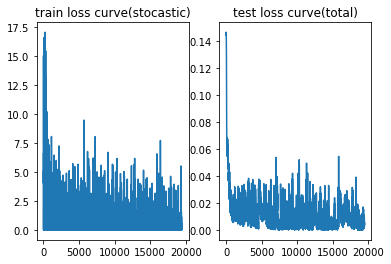

In [27]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.title('train loss curve(stocastic)')

plt.subplot(1,2,2)
plt.plot(test_loss)
plt.title('test loss curve(total)')

plt.show()

In [47]:
def get_real_position(position, mean, std):
    origin_X = position[0] * std[0] + mean[0]
    origin_Y = position[1] * std[1] + mean[1]
    
    return [origin_X, origin_Y]

In [58]:
# test第一个点坐标(给的预测值是比例)
index = 3

predict_y = ball_net(test_X[index].unsqueeze(0)).squeeze().detach().numpy()
origin_y = test_Y[index].numpy()

print('preditc_y:', get_real_position(predict_y, mean_for_predict, std_for_predict))
print('y:', get_real_position(origin_y, mean_for_predict, std_for_predict))

preditc_y: (-2617.74397866815, -3323.2595316428924)
y: (-2623.4809494203946, -4054.1801440027775)


In [59]:
test_X[index]

tensor([[ 1.8960e-01, -1.7882e-01, -8.2339e-01, -5.0953e-01, -9.2313e-01],
        [ 1.0119e-01, -2.0625e-01, -1.0620e+00, -5.6465e-01, -9.1306e-01],
        [-9.2153e-04, -2.4080e-01, -1.3652e+00, -6.4321e-01, -8.9367e-01],
        [-1.0688e-01, -2.7740e-01, -1.7126e+00, -7.4273e-01, -8.7118e-01],
        [-2.0912e-01, -3.1140e-01, -2.0439e+00, -8.3813e-01, -8.4487e-01],
        [-3.1340e-01, -3.5223e-01, -2.3438e+00, -9.4002e-01, -8.1399e-01],
        [-4.2888e-01, -3.9547e-01, -2.6272e+00, -1.0439e+00, -8.0149e-01],
        [-5.3189e-01, -4.3794e-01, -2.8474e+00, -1.1388e+00, -7.8540e-01],
        [-6.4925e-01, -4.8266e-01, -3.0451e+00, -1.2261e+00, -7.6534e-01],
        [-7.6063e-01, -5.3251e-01, -3.1984e+00, -1.3142e+00, -7.3952e-01],
        [-8.7913e-01, -5.8129e-01, -3.3287e+00, -1.3932e+00, -7.1320e-01],
        [-9.9167e-01, -6.3421e-01, -3.4197e+00, -1.4702e+00, -7.0092e-01],
        [-1.1135e+00, -6.8824e-01, -3.5014e+00, -1.5427e+00, -6.8045e-01],
        [-1.2312e+00, -7.